<a href="https://colab.research.google.com/github/teteumac/DileptonAnalysis/blob/master/pps_dilepton_ml_py_TesteCerto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!python3 -m pip install --user uproot4 awkward1 mplhep lightgbm

In [3]:
from __future__ import print_function, division

import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import sys
import seaborn as sns
from lightgbm import LGBMClassifier
import lightgbm as lgb
import sys

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import PrecisionRecallDisplay,precision_score,plot_roc_curve,recall_score,accuracy_score,log_loss,roc_auc_score,classification_report,f1_score,confusion_matrix,roc_curve,precision_recall_curve,plot_precision_recall_curve,average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
%matplotlib inline

In [5]:
proton_selection = "MultiRP"

df_signal = None
event_counts_signal = None
selections_str_signal = None


# SIGNAL

In [6]:
fileName_signal_exclusive = '/content/gdrive/My Drive/pps_ML/output-Exclusive130.h5'


with h5py.File( fileName_signal_exclusive, 'r' ) as f:
    print ( list(f.keys()) )
    dset = f['protons']
    print ( dset.shape )
    print ( dset[:,:] )
    dset_columns = f['columns']
    print ( dset_columns.shape )
    columns = list( dset_columns )
    print ( columns )
    columns_str = [ item.decode("utf-8") for item in columns ]
    print ( columns_str )
    
    dset_counts = f['event_counts']
    event_counts_signal = list( dset_counts )
    print ( event_counts_signal )
    
    dset_selections = f['selections']
    selections_ = list( dset_selections )
    print ( selections_ )
    selections_str_signal = [ item.decode("utf-8") for item in selections_ ]
    print ( selections_str_signal )
    
    df_signal = pd.DataFrame( dset, columns=columns_str )
    
    #df_signal = df_signal[ ['Xi', 'T', 'ThX', 'ThY', 'Weight' , "pt", "dz1", "XiMuMuPlus", "MultiRP",
    #                  'InvMass', 'ExtraPfCands', 'Acopl', 'XiMuMuMinus', 'PrimVertexZ'] ]

df_counts_signal_exclusive = pd.Series( event_counts_signal, index=selections_str_signal );
#print( df_counts_signal_exclusive )
msk_sig = (df_signal["InvMass"] >= 110. )

msk1_sig = None
msk2_sig = None
if proton_selection == "SingleRP":
    # Single-RP in pixel stations
    msk1_arm = ( df_signal["RPId1"] == 23 )
    msk2_arm = ( df_signal["RPId1"] == 123 )
    df_signal[ "XiMuMu" ] = np.nan
    df_signal[ "XiMuMu" ].where( ~msk1_arm, df_signal[ "XiMuMuPlus" ], inplace=True )
    df_signal[ "XiMuMu" ].where( ~msk2_arm, df_signal[ "XiMuMuMinus" ], inplace=True )
    #df_signal[ "XiMuMu" ][ msk2_arm ] = df_signal[ "XiMuMuMinus" ] 
    msk1_sig = msk_sig & ( df_signal["MultiRP"] == 0) & msk1_arm
    msk2_sig = msk_sig & ( df_signal["MultiRP"] == 0) & msk2_arm
elif proton_selection == "MultiRP":
    # Multi-RP
    msk1_arm = ( df_signal["Arm"] == 0 )
    msk2_arm = ( df_signal["Arm"] == 1 )
    df_signal[ "XiMuMu" ] = np.nan
    df_signal[ "XiMuMu" ].where( ~msk1_arm, df_signal[ "XiMuMuPlus" ], inplace=True )
    df_signal[ "XiMuMu" ].where( ~msk2_arm, df_signal[ "XiMuMuMinus" ], inplace=True )
    msk1_sig = msk_sig & ( df_signal["MultiRP"] == 1 ) & msk1_arm
    msk2_sig = msk_sig & ( df_signal["MultiRP"] == 1 ) & msk2_arm

df_signal = df_signal[ msk1_sig | msk2_sig ]
df_signal['target'] = 1
#print( df_signal )

['columns', 'event_counts', 'protons', 'selections']
(285346, 15)
[[ 3.83796021e-02 -1.04100592e-02  0.00000000e+00 ...  2.31398208e-03
   1.09153595e-02  2.14630890e+00]
 [ 3.81265022e-02 -1.48317078e-02  0.00000000e+00 ...  2.31398208e-03
   1.09153595e-02  2.14630890e+00]
 [ 3.94197255e-02 -4.52564545e-02 -1.39372623e-05 ...  2.31398208e-03
   1.09153595e-02  2.14630890e+00]
 ...
 [ 4.01983038e-02 -3.09351496e-02  0.00000000e+00 ...  1.85212595e-04
   3.05966531e-03 -5.42296886e+00]
 [ 3.63693014e-02 -1.42346010e-01  4.58586255e-05 ...  1.85212595e-04
   3.05966531e-03 -5.42296886e+00]
 [ 2.03184187e-02 -4.13834184e-01  0.00000000e+00 ...  1.50995244e-04
   4.87857127e-03  1.37020195e+00]]
(15,)
[b'Xi', b'T', b'ThX', b'ThY', b'Weight', b'pt', b'dz1', b'XiMuMuPlus', b'MultiRP', b'Arm', b'InvMass', b'ExtraPfCands', b'Acopl', b'XiMuMuMinus', b'PrimVertexZ']
['Xi', 'T', 'ThX', 'ThY', 'Weight', 'pt', 'dz1', 'XiMuMuPlus', 'MultiRP', 'Arm', 'InvMass', 'ExtraPfCands', 'Acopl', 'XiMuMuMinus'

In [7]:
df_signal

,Xi,T,ThX,ThY,Weight,pt,dz1,XiMuMuPlus,MultiRP,Arm,InvMass,ExtraPfCands,Acopl,XiMuMuMinus,PrimVertexZ,XiMuMu,target
2,0.039420,-0.045256,-0.000014,0.000030,1.208416,2.305948,0.004524,0.039576,1.0,0.0,270.187437,2.0,0.002314,0.010915,2.146309,0.039576,1
5,0.038857,-0.233490,-0.000031,0.000069,1.154366,1.486977,0.000970,0.037688,1.0,0.0,209.140113,1.0,0.000431,0.006868,0.247230,0.037688,1
8,0.045908,-0.294082,0.000085,-0.000001,1.009501,0.662313,0.006846,0.003999,1.0,1.0,177.482574,0.0,0.000732,0.046605,0.633745,0.046605,1
11,0.051476,-0.074141,-0.000041,0.000012,1.154366,0.219762,0.002116,0.050538,1.0,0.0,116.882889,1.0,0.000277,0.001600,2.956322,0.050538,1
16,0.040869,-0.038973,0.000029,-0.000010,1.241477,0.222753,0.002141,0.038771,1.0,0.0,139.021805,0.0,0.000297,0.002950,-0.174605,0.038771,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285330,0.030848,-0.041254,0.000031,-0.000005,1.251805,3.785275,0.002101,0.012214,1.0,1.0,251.145794,11.0,0.002766,0.030564,3.360268,0.030564,1
285335,0.035900,-0.360529,0.000017,-0.000092,0.860627,2.222014,0.000058,0.007713,1.0,1.0,218.789124,3.0,0.000580,0.036727,2.482682,0.036727,1
285338,0.051403,-0.494220,0.000070,-0.000086,0.795806,5.244809,0.000192,0.011024,1.0,1.0,301.041639,0.0,0.000083,0.048657,-0.382731,0.048657,1
285341,0.042523,-0.064319,-0.000025,-0.000031,1.518433,0.868856,0.006715,0.002110,1.0,1.0,127.194376,3.0,0.000267,0.045377,0.996049,0.045377,1


In [8]:

fileName_signal_semiexclusive = '/content/gdrive/My Drive/pps_ML/output-SemiExclusive130.h5'

with h5py.File( fileName_signal_semiexclusive, 'r' ) as f:
    print ( list(f.keys()) )
    dset = f['protons']
    print ( dset.shape )
    print ( dset[:,:] )
    dset_columns = f['columns']
    print ( dset_columns.shape )
    columns = list( dset_columns )
    print ( columns )
    columns_str = [ item.decode("utf-8") for item in columns ]
    print ( columns_str )
    
    dset_counts = f['event_counts']
    event_counts_signal = list( dset_counts )
    print ( event_counts_signal )
    
    dset_selections = f['selections']
    selections_ = list( dset_selections )
    print ( selections_ )
    selections_str_signal = [ item.decode("utf-8") for item in selections_ ]
    print ( selections_str_signal )
    
    df_signal_semi = pd.DataFrame( dset, columns=columns_str )                      

df_counts_signal_semiexclusive = pd.Series( event_counts_signal, index=selections_str_signal );
print( df_counts_signal_semiexclusive )

msk_signal_semi = (df_signal_semi["InvMass"] >= 110)

msk1_signal_semi = None
msk2_signal_semi = None
if proton_selection == "SingleRP":
    # Single-RP in pixel stations
    msk1_arm = ( df_signal_semi["RPId1"] == 23 )
    msk2_arm = ( df_signal_semi["RPId1"] == 123 )
    df_signal_semi[ "XiMuMu" ] = np.nan
    df_signal_semi[ "XiMuMu" ].where( ~msk1_arm, df_signal_semi[ "XiMuMuPlus" ], inplace=True )
    df_signal_semi[ "XiMuMu" ].where( ~msk2_arm, df_signal_semi[ "XiMuMuMinus" ], inplace=True )
    #df_signal[ "XiMuMu" ][ msk2_arm ] = df_signal[ "XiMuMuMinus" ] 
    msk1_sig = msk_sig & ( df_signal_semi["MultiRP"] == 0) & msk1_arm
    msk2_sig = msk_sig & ( df_signal_semi["MultiRP"] == 0) & msk2_arm
elif proton_selection == "MultiRP":
    # Multi-RP
    msk1_arm = ( df_signal_semi["Arm"] == 0 )
    msk2_arm = ( df_signal_semi["Arm"] == 1 )
    df_signal_semi[ "XiMuMu" ] = np.nan
    df_signal_semi[ "XiMuMu" ].where( ~msk1_arm, df_signal_semi[ "XiMuMuPlus" ], inplace=True )
    df_signal_semi[ "XiMuMu" ].where( ~msk2_arm, df_signal_semi[ "XiMuMuMinus" ], inplace=True )
    msk1_signal_semi = msk_signal_semi & ( df_signal_semi["MultiRP"] == 1 ) & msk1_arm
    msk2_signal_semi = msk_signal_semi & ( df_signal_semi["MultiRP"] == 1 ) & msk2_arm

df_signal_semi = df_signal_semi[ msk1_signal_semi | msk2_signal_semi ]
df_signal_semi['target'] = 2
#print( df_signal_semi )

['columns', 'event_counts', 'protons', 'selections']
(163308, 15)
[[ 3.63221094e-02 -1.15129407e-02  0.00000000e+00 ...  8.10643436e-03
   3.94431096e-02  9.19979155e-01]
 [ 3.58829275e-02 -1.85621530e-02  0.00000000e+00 ...  8.10643436e-03
   3.94431096e-02  9.19979155e-01]
 [ 3.79030667e-02 -5.86915016e-02 -1.58526582e-05 ...  8.10643436e-03
   3.94431096e-02  9.19979155e-01]
 ...
 [ 7.24671632e-02 -3.74770537e-02  0.00000000e+00 ...  1.93572367e-03
   3.88485338e-03  1.68140030e+00]
 [ 7.22354800e-02 -4.11085933e-02  0.00000000e+00 ...  1.93572367e-03
   3.88485338e-03  1.68140030e+00]
 [ 7.44942874e-02 -1.22550160e-01 -1.23130258e-05 ...  1.93572367e-03
   3.88485338e-03  1.68140030e+00]]
(15,)
[b'Xi', b'T', b'ThX', b'ThY', b'Weight', b'pt', b'dz1', b'XiMuMuPlus', b'MultiRP', b'Arm', b'InvMass', b'ExtraPfCands', b'Acopl', b'XiMuMuMinus', b'PrimVertexZ']
['Xi', 'T', 'ThX', 'ThY', 'Weight', 'pt', 'dz1', 'XiMuMuPlus', 'MultiRP', 'Arm', 'InvMass', 'ExtraPfCands', 'Acopl', 'XiMuMuMinus'

In [9]:
df_signal_semi

,Xi,T,ThX,ThY,Weight,pt,dz1,XiMuMuPlus,MultiRP,Arm,InvMass,ExtraPfCands,Acopl,XiMuMuMinus,PrimVertexZ,XiMuMu,target
2,0.037903,-0.058692,-0.000016,0.000034,1.069333,3.308203,0.000656,0.007522,1.0,1.0,223.903747,0.0,0.008106,0.039443,0.919979,0.039443,2
5,0.029967,-0.619747,0.000104,-0.000065,1.212219,1.036125,0.000865,0.030873,1.0,0.0,151.804255,1.0,0.004339,0.004417,3.731446,0.030873,2
8,0.056337,-0.042861,0.000028,-0.000014,1.259455,4.853525,0.001198,0.060257,1.0,0.0,515.383351,1.0,0.011116,0.026086,4.791252,0.060257,2
11,0.054751,-0.012992,0.000004,0.000016,1.092546,157.975805,0.000267,0.010878,1.0,1.0,264.764781,1.0,0.152455,0.051705,-3.785355,0.051705,2
14,0.085117,-0.069233,0.000014,0.000038,1.212219,37.766873,0.000407,0.010340,1.0,1.0,374.321953,1.0,0.062509,0.081000,-0.906035,0.081000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163291,0.037883,-0.147633,0.000050,-0.000033,1.561522,16.232387,0.001012,0.037889,1.0,0.0,157.571687,4.0,0.010142,0.003919,0.540850,0.037889,2
163294,0.045255,-0.029653,0.000003,-0.000026,0.973364,1.252627,0.005973,0.001716,1.0,1.0,116.170305,0.0,0.001037,0.046531,-0.896035,0.046531,2
163299,0.061012,-0.178772,-0.000060,0.000030,1.182239,4.131175,0.004376,0.034717,1.0,1.0,598.238735,0.0,0.004072,0.061002,-2.230065,0.061002,2
163304,0.043050,-0.054138,0.000032,-0.000017,1.154672,139.103603,0.000232,0.005914,1.0,1.0,160.153401,0.0,0.472806,0.045022,3.994493,0.045022,2


# Background

In [10]:
df_bkg_list = []
df_counts_bkg_list = []

resample_factor = 20

fileNames_bkg = [
'/content/gdrive/My Drive/pps_ML/output-DatadrivenB.h5',
'/content/gdrive/My Drive/pps_ML/output-DatadrivenC0.h5',
'/content/gdrive/My Drive/pps_ML/output-DatadrivenC1.h5',
'/content/gdrive/My Drive/pps_ML/output-DatadrivenC2.h5',
'/content/gdrive/My Drive/pps_ML/output-DatadrivenC3.h5',
'/content/gdrive/My Drive/pps_ML/output-DatadrivenE0.h5',
'/content/gdrive/My Drive/pps_ML/output-DatadrivenE1.h5',
'/content/gdrive/My Drive/pps_ML/output-DatadrivenE2.h5',
'/content/gdrive/My Drive/pps_ML/output-DatadrivenE3.h5',
'/content/gdrive/My Drive/pps_ML/output-DatadrivenE4.h5',
'/content/gdrive/My Drive/pps_ML/output-DatadrivenE5.h5',
'/content/gdrive/My Drive/pps_ML/output-DatadrivenE6.h5',
'/content/gdrive/My Drive/pps_ML/output-DatadrivenF0.h5',
'/content/gdrive/My Drive/pps_ML/output-DatadrivenF1.h5'
]

for file_ in fileNames_bkg:
    with h5py.File( file_, 'r' ) as f:
        #print ( file_ )    
        #print ( list(f.keys()) )
        dset = f['protons']
        #print ( dset.shape )
        #print ( dset[:,:] )
        
        dset_columns = f['columns']
        #print ( dset_columns.shape )
        columns = list( dset_columns )
        #print ( columns )
        columns_str = [ item.decode("utf-8") for item in columns ]
        #print ( columns_str )

        dset_selections = f['selections']
        selections_ = [ item.decode("utf-8") for item in dset_selections ]
        #print ( selections_ )
        
        dset_counts = f['event_counts']
        df_counts_bkg_list.append( pd.Series( dset_counts, index=selections_ ) )
        #print ( df_counts_bkg_list[-1] )
       
        chunk_size = 1000000
        entries = dset.shape[0]
        start_ = list( range( 0, entries, chunk_size ) )
        stop_ = start_[1:]
        stop_.append( entries )
        #print ( start_ )
        #print ( stop_ )
        for idx in range( len( start_ ) ):
            #print ( start_[idx], stop_[idx] )
            #print ( dset[ start_[idx] : stop_[idx] ] )
            df_ = pd.DataFrame( dset[ start_[idx] : stop_[idx] ], columns=columns_str )
            #df_ = df_[ ['Run', 'LumiSection', 'EventNum', 'CrossingAngle', 
            #            'MultiRP', 'Arm', 'RPId1', 'RPId2', 'TrackX1', 'TrackY1', 'TrackX2', 'TrackY2',
            #            'Xi', 'T', 'ThX', 'ThY', 'Time', 'Weight',
            #            'Muon0Pt', 'Muon1Pt', 'InvMass', 'ExtraPfCands', 'Acopl', 'XiMuMuPlus', 'XiMuMuMinus'] ].astype( { "Run": "int64", "LumiSection": "int64", "EventNum": "int64", "MultiRP": "int32", "Arm": "int32", "RPId1": "int32", "RPId2": "int32", "ExtraPfCands": "int32" } )
            df_bkg_list.append( df_ )
            #print ( df_bkg_list[-1].head() )
            #print ( len( df_bkg_list[-1] ) )

df_counts_bkg = df_counts_bkg_list[0]
for idx in range( 1, len( df_counts_bkg_list ) ):
    df_counts_bkg = df_counts_bkg.add( df_counts_bkg_list[idx] )
print( df_counts_bkg )            

df_bkg = pd.concat( df_bkg_list )

msk_bkg = ( df_bkg["InvMass"] >= 110. )

msk1_bkg = None
msk2_bkg = None
if proton_selection == "SingleRP":
    # Single-RP in pixel stations
    msk1_arm = ( df_bkg["RPId1"] == 23 )
    msk2_arm = ( df_bkg["RPId1"] == 123 )
    df_bkg[ "XiMuMu" ] = np.nan
    df_bkg[ "XiMuMu" ].where( ~msk1_arm, df_bkg[ "XiMuMuPlus" ], inplace=True )
    df_bkg[ "XiMuMu" ].where( ~msk2_arm, df_bkg[ "XiMuMuMinus" ], inplace=True )
    msk1_bkg = msk_bkg & ( df_bkg["MultiRP"] == 0) & msk1_arm
    msk2_bkg = msk_bkg & ( df_bkg["MultiRP"] == 0) & msk2_arm
elif proton_selection == "MultiRP":
    # Multi-RP
    msk1_arm = ( df_bkg["Arm"] == 0 )
    msk2_arm = ( df_bkg["Arm"] == 1 )
    df_bkg[ "XiMuMu" ] = np.nan
    df_bkg[ "XiMuMu" ].where( ~msk1_arm, df_bkg[ "XiMuMuPlus" ], inplace=True )
    df_bkg[ "XiMuMu" ].where( ~msk2_arm, df_bkg[ "XiMuMuMinus" ], inplace=True )
    msk1_bkg = msk_bkg & ( df_bkg["MultiRP"] == 1 ) & msk1_arm
    msk2_bkg = msk_bkg & ( df_bkg["MultiRP"] == 1 ) & msk2_arm

df_bkg = df_bkg[ msk1_bkg | msk2_bkg ]
df_bkg['target'] = 0 

All           834616760
Muon            8130540
Vertex          8130540
ProtonsRnd      6573240
dtype: int64


In [11]:
df_bkg

,Xi,T,ThX,ThY,Weight,pt,dz1,XiMuMuPlus,MultiRP,Arm,InvMass,ExtraPfCands,Acopl,XiMuMuMinus,PrimVertexZ,XiMuMu,target
11,0.047109,-0.354380,-0.000084,-0.000041,1.0,7.685577,0.000390,0.003133,1.0,0.0,111.362865,15.0,0.016124,0.023537,1.304841,0.003133,0
24,0.056993,-0.267702,-0.000065,-0.000049,1.0,2.399811,0.009210,0.051660,1.0,1.0,110.799858,21.0,0.012886,0.001407,-6.981695,0.001407,0
32,0.057765,-0.720996,0.000046,0.000126,1.0,15.730142,0.000485,0.021790,1.0,1.0,122.661834,31.0,0.036588,0.004153,0.063312,0.004153,0
49,0.038785,-0.626253,0.000034,-0.000119,1.0,55.417190,0.000862,0.004999,1.0,0.0,129.872817,104.0,0.259930,0.023602,-1.494984,0.004999,0
50,0.096397,-0.232224,-0.000041,0.000065,1.0,55.417190,0.000862,0.004999,1.0,1.0,129.872817,104.0,0.259930,0.023602,-1.494984,0.023602,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551473,0.065033,-0.131820,0.000053,-0.000020,1.0,58.989347,0.002524,0.017128,1.0,0.0,203.377973,33.0,0.178821,0.015492,1.103179,0.017128,0
551476,0.126707,-0.745779,-0.000130,0.000054,1.0,74.172634,0.002349,0.008908,1.0,1.0,173.770371,46.0,0.228126,0.023713,7.249494,0.023713,0
551483,0.065033,-0.131820,0.000053,-0.000020,1.0,25.590560,0.000666,0.006951,1.0,0.0,188.717403,34.0,0.124428,0.030874,-0.958152,0.006951,0
551492,0.049043,-0.284848,0.000077,0.000032,1.0,14.458489,0.003204,0.015093,1.0,0.0,173.725739,11.0,0.054144,0.011914,3.609064,0.015093,0


# NORMALIZAÇÃO E CONTAGEM DE EVENTOS

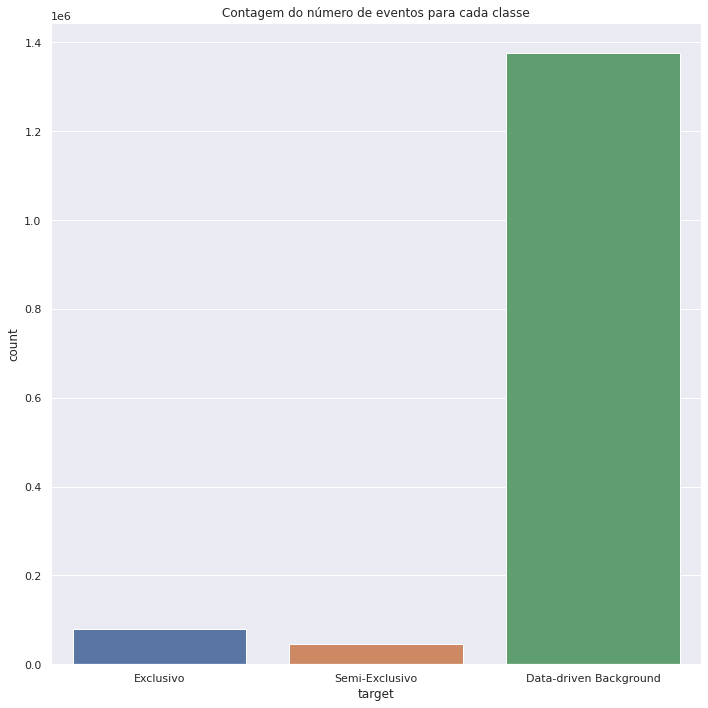

In [12]:
n_events_h_elastic = 200000
n_events_h_inel_el = 200000
n_events_h_dy = 48675378.
total_lumi = 37.498268
limit_lumi = 18.346268
rap_gap_surv_elastic = 0.89
rap_gap_surv_inel_el = 0.76
rap_gap_surv_inelastic = 0.13
number_of_samples = 20

scale_factor_elastic_x130 = limit_lumi*rap_gap_surv_elastic*0.017254036*1000 / n_events_h_elastic
scale_factor_inel_el_x130 = limit_lumi*rap_gap_surv_inel_el*0.025643500*1000 / n_events_h_inel_el 
scale_factor_dy = limit_lumi*5334000 / n_events_h_dy
scale_factor_dy_resample = limit_lumi*5334000 / ( n_events_h_dy*number_of_samples )
scale_factor_pseudoback = 1/number_of_samples

df_signal.loc[:,'Weight'] *= scale_factor_elastic_x130
df_signal_semi.loc[:,'Weight'] *= scale_factor_inel_el_x130
df_bkg.loc[:,'Weight'] *= scale_factor_pseudoback

DataSet2 = pd.concat([df_signal,df_signal_semi,df_bkg], ignore_index = True)

fig= plt.figure( figsize=(10,10) )
label_conts = DataSet2['target'].replace([0,1,2],['Data-driven Background','Exclusivo','Semi-Exclusivo'])
sns.set(style="darkgrid")
sns.countplot(x=label_conts, data=DataSet2)
#plt.style.use(hep.style.CMS)
#fig= plt.figure( figsize=(10,10) )
plt.title('Contagem do número de eventos para cada classe')
#plt.yscale('log')
plt.tight_layout()

In [13]:
drop_columns = ['target', 'Weight', "MultiRP", "Arm", 'XiMuMuPlus','XiMuMuMinus']
# Elemina as colunas que desejar

# PROCURA POR HIPERPARÂMETROS E TREINAMENTO DO MODELO

In [14]:

DataSet_Train, dataset_test = train_test_split( DataSet2, test_size = 0.50, random_state = 41 )
'''
with h5py.File( 'amostra_train' + '.h5', 'w') as f:
    dset = f.create_dataset( 'train', data=DataSet_Train )

with h5py.File( 'amostra_test' + '.h5', 'w') as f:
    dset = f.create_dataset( 'test', data=dataset_test )    
'''
Norm_Test = 1/0.50

y_train_ = DataSet_Train['target'].replace(2,1) # Muda os valores de 2 para 1
y_test_ = dataset_test['target'].replace(2,1)

train_data = lgb.Dataset(DataSet_Train.drop( drop_columns , axis = 1 ), label = y_train_ )
test_data = lgb.Dataset(dataset_test.drop( drop_columns , axis = 1 ) , label = y_test_ )

n_iter = 4
cv = 2
scoring = [ 'roc_auc_score','f1_score','precision_score','recall_score' ]

param_grid = {
    'learning_rate': list(np.arange(0.0001,1,0.001)), 
    'n_estimators': list(range(100, 1000, 50)),
    'num_leaves': list(range(1, 100, 2)),
    'max_depth': list(range(0, 150, 3)),
    'min_child_samples': list(range(0, 100, 2)),
    'subsample': list(np.arange(0.01,1,0.01)), 
    'colsample_bytree':list(np.arange(0.1,1,0.1))
              }  

mdl = LGBMClassifier( boosting_type = 'gbdt' , objective = 'binary' )


search = RandomizedSearchCV( estimator = mdl, param_distributions = param_grid, n_iter = n_iter, refit=scoring ,cv = cv, verbose = 1 )

search_result = search.fit(DataSet_Train.drop( drop_columns , axis = 1), y_train_)

# Results
print("Best: %f using %s" % ( search_result.best_score_, search_result.best_params_ ) )
print('\n')

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.9min finished


Best: 0.988512 using {'subsample': 0.49, 'num_leaves': 9, 'n_estimators': 500, 'min_child_samples': 10, 'max_depth': 21, 'learning_rate': 0.4521, 'colsample_bytree': 0.6}




In [15]:
#sns.pairplot(DataSet_Train.drop(['target', 'Weight', "MultiRP","Arm"], axis = 1))

In [16]:
predict_proba_LGBM = search_result.predict_proba( dataset_test.drop( drop_columns , axis = 1 ) )[:,1] 

fpr_lgb, tpr_lgb, thresholds_lgb = roc_curve( y_test_, predict_proba_LGBM ) # fpr -> false positive rate | tpr -> true positive rate
prec_lgb, rec_lgb, threshs_lgb = precision_recall_curve( y_test_, predict_proba_LGBM ) # prec -> precision | rec -> recall 
f1 = 2 * ( prec_lgb * rec_lgb ) / ( prec_lgb + rec_lgb )
threshs_lgb  = np.concatenate( [ threshs_lgb , [1] ] , axis = 0 )

bidx = np.argmax(prec_lgb*rec_lgb)
best_cut = threshs_lgb[bidx]
print('\n',' Best Cut ------>> ', best_cut,'\n')
y_pred_cut = predict_proba_LGBM >= best_cut


  Best Cut ------>>  0.48936262720547075 



Confusion matrix:
 [[685079   2709]
 [  2623  59593]]


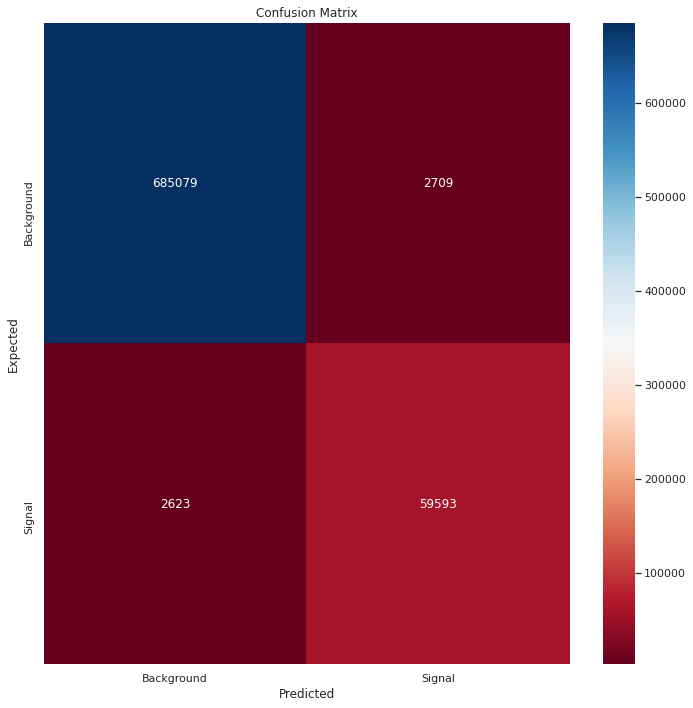

In [17]:
from pandas import DataFrame

fig= plt.figure( figsize=(10,10) )
conf_mat = confusion_matrix(y_true=y_test_, y_pred=y_pred_cut)
print('Confusion matrix:\n', conf_mat)
conf_mat = DataFrame(conf_mat)
conf_mat = conf_mat.rename(columns={0:'Background', 1:'Signal'})
conf_mat = conf_mat.T
conf_mat = conf_mat.rename(columns={0:'Background', 1:'Signal'})
conf_mat = conf_mat.T
sns.heatmap(conf_mat, annot=True, fmt="d",cmap = 'RdBu')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.tight_layout()
plt.show()
#plt.savefig('/home/matheus/test/confusion_matrix.png')
plt.close()


<Figure size 720x720 with 0 Axes>

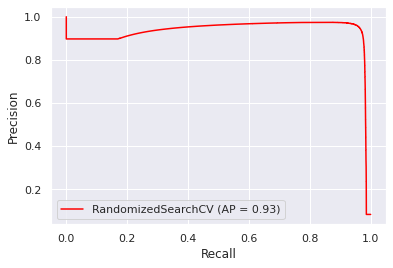

In [18]:
plt.figure( figsize=(10,10) )
plot_precision_recall_curve( search, dataset_test.drop( drop_columns ,axis=1),y_test_, color = 'red')
#plt.style.use(hep.style.CMS)
#hep.cms.cmslabel(data=False, paper=False, year='$18.34 fb^{-1}$')
plt.show()
#plt.savefig('/home/matheus/test/pre_rec.png')
plt.close()

<Figure size 720x720 with 0 Axes>

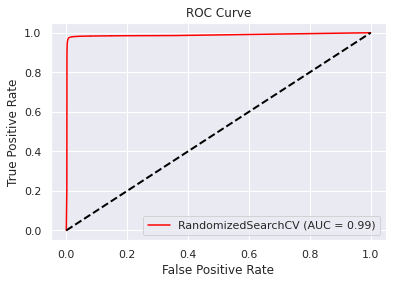

In [19]:
fig= plt.figure( figsize=(10,10) )
plot_roc_curve( search, dataset_test.drop( drop_columns ,axis=1),y_test_, color = 'red')
plt.title("ROC Curve")
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
#plt.style.use(hep.style.CMS)
#hep.cms.cmslabel(data=False, paper=False, year='$18.34 fb^{-1}$')
plt.show()
#plt.savefig('/home/matheus/test/roc.png')
plt.close()


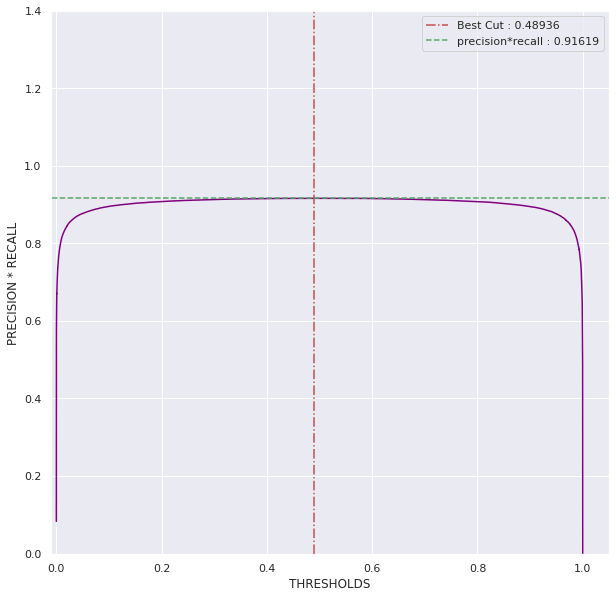

In [20]:
fig= plt.figure( figsize=(10,10) )
plt.plot( threshs_lgb , prec_lgb*rec_lgb ,  color = 'purple' )
plt.plot( [ best_cut,best_cut ] , [0,(prec_lgb * rec_lgb).max()*2] ,"-.r",label='Best Cut : {:2.5f}'.format(best_cut) )
plt.plot( [-0.1,1.1] , [ (prec_lgb*rec_lgb).max(),(prec_lgb*rec_lgb).max()], "--g",label='precision*recall : {:2.5f}'.format((prec_lgb*rec_lgb).max()) )
plt.ylabel( 'PRECISION * RECALL' )
plt.xlabel(    'THRESHOLDS'    )
plt.ylim( -0.002 , 1.4 )
plt.xlim( -0.01 , 1.05)
plt.legend(loc="best")
#plt.style.use(hep.style.CMS)
#hep.cms.cmslabel(data=False, paper=False, year='$18.34 fb^{-1}$')
plt.show()
#plt.savefig('/home/matheus/test/prec_x_rec.png')
plt.close()

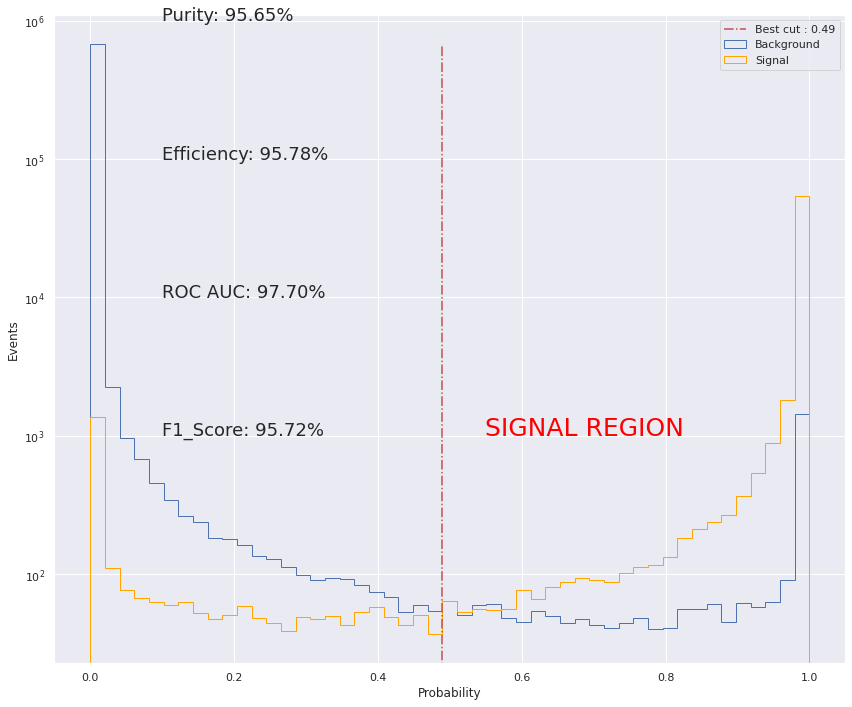

<Figure size 1440x864 with 0 Axes>

In [21]:
fig= plt.figure( figsize=(12,10) )
hbgt_lgb =  plt.hist(predict_proba_LGBM[y_test_==0],bins=np.linspace(0,1,50), histtype='step',label='Background', color = 'b')
hsigt_lgb = plt.hist(predict_proba_LGBM[y_test_==1],bins=np.linspace(0,1,50), histtype='step',label='Signal', color = 'orange')
uppery_lgb=np.max(hbgt_lgb[0])
plt.plot([best_cut,best_cut],[0,uppery_lgb],"-.r",label='Best cut : {:2.2f}'.format(best_cut))
plt.xlabel("Probability")
plt.ylabel("Events")
plt.legend(loc="upper right")
plt.text(0.1,80e4, "Purity: {:2.2f}%".format(100*precision_score(y_test_,y_pred_cut)),fontsize = 18)
plt.text(0.1,10e4, "Efficiency: {:2.2f}%".format(100*recall_score(y_test_,y_pred_cut)),fontsize = 18)
#plt.text(0.1,10e3, "Accuracy: {:2.2f}%".format(100*accuracy_score(y_test_,y_pred_cut)), fontsize = 18)
plt.text(0.1,10e3, "ROC AUC: {:2.2f}%".format(100*roc_auc_score(y_test_,y_pred_cut)), fontsize = 18)
plt.text(0.1,10e2, "F1_Score: {:2.2f}%".format(100*f1_score(y_test_,y_pred_cut)), fontsize = 18)
plt.text(best_cut+0.06,1000, 'SIGNAL REGION', color = 'red', fontsize = 25)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,3), useMathText = True)
#plt.style.use(hep.style.CMS)
#hep.cms.cmslabel(data=False, paper=False, year='$18.34 fb^{-1}$')
plt.yscale('log')
plt.tight_layout()
plt.figure(figsize = (20, 12))
plt.show()
#plt.savefig('/home/matheus/test/discriminante.png')
plt.close()

## **DADOS**

In [22]:
df_data_list = []
df_counts_data_list = []

fileNames = [
'/content/gdrive/My Drive/pps_ML/output-DataB.h5',
'/content/gdrive/My Drive/pps_ML/output-DataC0.h5',
'/content/gdrive/My Drive/pps_ML/output-DataC1.h5',
'/content/gdrive/My Drive/pps_ML/output-DataC2.h5',
'/content/gdrive/My Drive/pps_ML/output-DataC3.h5',
'/content/gdrive/My Drive/pps_ML/output-DataE0.h5',
'/content/gdrive/My Drive/pps_ML/output-DataE1.h5',
'/content/gdrive/My Drive/pps_ML/output-DataE2.h5',
'/content/gdrive/My Drive/pps_ML/output-DataE3.h5',
'/content/gdrive/My Drive/pps_ML/output-DataE4.h5',
'/content/gdrive/My Drive/pps_ML/output-DataE5.h5',
'/content/gdrive/My Drive/pps_ML/output-DataE6.h5',
'/content/gdrive/My Drive/pps_ML/output-DataF0.h5',
'/content/gdrive/My Drive/pps_ML/output-DataF1.h5'
]

In [23]:
for file_ in fileNames:
    with h5py.File( file_, 'r' ) as f:
        print ( f )
        print ( list(f.keys()) )
        dset = f['protons']
        print ( dset.shape )
        print ( dset[:,:] )
        
        dset_columns = f['columns']
        print ( dset_columns.shape )
        columns = list( dset_columns )
        print ( columns )
        columns_str = [ item.decode("utf-8") for item in columns ]
        print ( columns_str )

        dset_selections = f['selections']
        selections_ = [ item.decode("utf-8") for item in dset_selections ]
        print ( selections_ )  
        
        dset_counts = f['event_counts']
        df_counts_data_list.append( pd.Series( dset_counts, index=selections_ ) )
        print ( df_counts_data_list[-1] )
        
        chunk_size = 1000000
        entries = dset.shape[0]
        start_ = list( range( 0, entries, chunk_size ) )
        stop_ = start_[1:]
        stop_.append( entries )
        print ( start_ )
        print ( stop_ )
        for idx in range( len( start_ ) ):
            print ( start_[idx], stop_[idx] )
            #print ( dset[ start_[idx] : stop_[idx] ] )
            df_ = pd.DataFrame( dset[ start_[idx] : stop_[idx] ], columns=columns_str )
            df_data_list.append( df_ )
            print ( df_data_list[-1].head() )
            print ( len( df_data_list[-1] ) )

<HDF5 file "output-DataB.h5" (mode r)>
['columns', 'event_counts', 'protons', 'selections']
(114077, 15)
[[ 3.30866091e-02 -1.12724574e-02  0.00000000e+00 ...  6.37866570e-02
   6.12093887e-02  2.94041586e+00]
 [ 7.75028616e-02 -2.33704939e-01  0.00000000e+00 ...  6.37866570e-02
   6.12093887e-02  2.94041586e+00]
 [ 8.38358924e-02 -2.66309064e-02  0.00000000e+00 ...  6.37866570e-02
   6.12093887e-02  2.94041586e+00]
 ...
 [ 7.23123550e-02 -4.47298028e-02  0.00000000e+00 ...  9.07171559e-03
   7.18824331e-03 -4.05744672e-01]
 [ 6.61505014e-02 -6.89206421e-02  3.82464277e-05 ...  9.07171559e-03
   7.18824331e-03 -4.05744672e-01]
 [ 1.17798097e-01 -1.35632977e-01  0.00000000e+00 ...  7.14619650e-01
   5.19973212e-02  2.34783769e+00]]
(15,)
[b'Xi', b'T', b'ThX', b'ThY', b'Weight', b'pt', b'dz1', b'XiMuMuPlus', b'MultiRP', b'Arm', b'InvMass', b'ExtraPfCands', b'Acopl', b'XiMuMuMinus', b'PrimVertexZ']
['Xi', 'T', 'ThX', 'ThY', 'Weight', 'pt', 'dz1', 'XiMuMuPlus', 'MultiRP', 'Arm', 'InvMass',

In [24]:
df_counts_data = df_counts_data_list[0];
for idx in range( 1, len(df_counts_data_list) ):
    df_counts_data = df_counts_data.add( df_counts_data_list[idx] )
df_counts_data


All        41730838
Muon         406527
Vertex       406527
Protons      328662
dtype: int64

In [25]:
df_data = pd.concat( df_data_list )
print( df_data )
print( df_data.columns )

             Xi         T       ThX  ...     Acopl  XiMuMuMinus  PrimVertexZ
0      0.033087 -0.011272  0.000000  ...  0.063787     0.061209     2.940416
1      0.077503 -0.233705  0.000000  ...  0.063787     0.061209     2.940416
2      0.083836 -0.026631  0.000000  ...  0.063787     0.061209     2.940416
3      0.040378 -0.157708  0.000000  ...  0.063787     0.061209     2.940416
4      0.074111 -0.020789  0.000000  ...  0.002248     0.079817    -2.349462
...         ...       ...       ...  ...       ...          ...          ...
27570  0.148048 -0.590158 -0.000056  ...  0.910754     0.033867     1.625465
27571  0.039347 -1.365259  0.000000  ...  0.054144     0.011914     3.609064
27572  0.037682 -1.375249  0.000000  ...  0.054144     0.011914     3.609064
27573  0.047386 -0.370985 -0.000064  ...  0.054144     0.011914     3.609064
27574  0.136905 -0.448938  0.000000  ...  0.552112     0.011744     4.525947

[1132233 rows x 15 columns]
Index(['Xi', 'T', 'ThX', 'ThY', 'Weight', 'pt',

In [26]:
msk_data = ( df_data["InvMass"] >= 0. )

msk1_data = None
msk2_data = None
if proton_selection == "SingleRP":
    # Single-RP in pixel stations
    msk1_arm = ( df_data["RPId1"] == 23 )
    msk2_arm = ( df_data["RPId1"] == 123 )
    df_data[ "XiMuMu" ] = np.nan
    df_data[ "XiMuMu" ].where( ~msk1_arm, df_data[ "XiMuMuPlus" ], inplace=True )
    df_data[ "XiMuMu" ].where( ~msk2_arm, df_data[ "XiMuMuMinus" ], inplace=True )
    msk1_data = msk_data & ( df_data["MultiRP"] == 0) & msk1_arm
    msk2_data = msk_data & ( df_data["MultiRP"] == 0) & msk2_arm
elif proton_selection == "MultiRP":
    # Multi-RP
    msk1_arm = ( df_data["Arm"] == 0 )
    msk2_arm = ( df_data["Arm"] == 1 )
    df_data[ "XiMuMu" ] = np.nan
    df_data[ "XiMuMu" ].where( ~msk1_arm, df_data[ "XiMuMuPlus" ], inplace=True )
    df_data[ "XiMuMu" ].where( ~msk2_arm, df_data[ "XiMuMuMinus" ], inplace=True )
    msk1_data = msk_data & ( df_data["MultiRP"] == 1 ) & msk1_arm
    msk2_data = msk_data & ( df_data["MultiRP"] == 1 ) & msk2_arm

df_data = df_data[ msk1_data | msk2_data ]
print( df_data )
print( df_data.columns )

             Xi         T       ThX  ...  XiMuMuMinus  PrimVertexZ    XiMuMu
6      0.073120 -0.135776  0.000006  ...     0.079817    -2.349462  0.001196
16     0.077827 -0.568799 -0.000113  ...     0.004153     0.063312  0.021790
19     0.040280 -0.274025 -0.000035  ...     0.009972     3.809169  0.009236
22     0.079453 -0.156619 -0.000022  ...     0.012194    -5.060766  0.021762
30     0.061976 -0.140918  0.000040  ...     0.023602    -1.494984  0.004999
...         ...       ...       ...  ...          ...          ...       ...
27548  0.132713 -0.235384 -0.000007  ...     0.020205     0.354908  0.020205
27552  0.155300 -0.633016 -0.000088  ...     0.002279    -1.112250  0.002279
27560  0.137893 -0.556083 -0.000111  ...     0.023713     7.249494  0.023713
27570  0.148048 -0.590158 -0.000056  ...     0.033867     1.625465  0.033867
27573  0.047386 -0.370985 -0.000064  ...     0.011914     3.609064  0.011914

[150472 rows x 16 columns]
Index(['Xi', 'T', 'ThX', 'ThY', 'Weight', 'pt', 

In [27]:
MonteCarlo_DrellYan = DataFrame( np.array( dataset_test[ dataset_test.target == 0 ]  ) , columns = DataSet_Train.columns)
MonteCarlo_Exclusive = DataFrame( np.array( dataset_test[ dataset_test.target == 1 ]  ) , columns = DataSet_Train.columns )
MonteCarlo_SemiExclusive = DataFrame( np.array( dataset_test[ dataset_test.target == 2 ] ) , columns = DataSet_Train.columns)
#print(MonteCarlo_SemiExclusive)
#print(MonteCarlo_Exclusive)
#print(MonteCarlo_DrellYan)

In [28]:
predict_proba_LGBM_background = search_result.predict_proba( MonteCarlo_DrellYan.drop( drop_columns , axis = 1 ) )[:,1]
predict_proba_LGBM_exclusivo = search_result.predict_proba( MonteCarlo_Exclusive.drop( drop_columns , axis = 1 ) )[:,1]
predict_proba_LGBM_semiexclusivo = search_result.predict_proba( MonteCarlo_SemiExclusive.drop( drop_columns , axis = 1 ) )[:,1]
predict_proba_LGBM_Data = search_result.predict_proba( df_data.drop( [ 'MultiRP','Arm', 'Weight', 'XiMuMuPlus', 'XiMuMuMinus'] , axis = 1 ) )[:,1]

In [29]:
class_true = dataset_test['target'].replace(2,1)

prec, rec, threshs = precision_recall_curve( y_test_, predict_proba_LGBM , sample_weight = dataset_test.Weight*Norm_Test ) # prec -> precision | rec -> recall 
fpr, tpr, thresholds = roc_curve( y_test_, predict_proba_LGBM , sample_weight = dataset_test.Weight*Norm_Test )
f1 = 2 * ( prec * rec ) / ( prec + rec )
threshs  = np.concatenate( [ threshs , [1] ] , axis = 0 )

argmax = np.argmax( prec * rec )
best_cut = threshs[argmax]
print('\n',' Best Cut ------>> ', best_cut,'\n')
y_pred_cut = predict_proba_LGBM >= best_cut
y_pred_cut = np.array(y_pred_cut)


  Best Cut ------>>  0.943790905017744 



<Figure size 720x720 with 0 Axes>

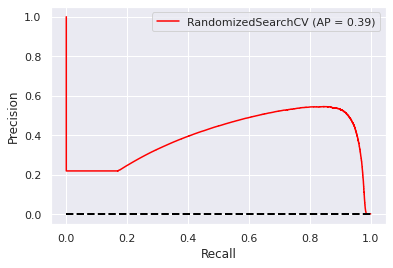

In [30]:
fig= plt.figure( figsize=(10,10) )
plot_precision_recall_curve( search, dataset_test.drop( drop_columns ,axis=1),y_test_, color = 'red',sample_weight = dataset_test.Weight*Norm_Test)
#plt.style.use(hep.style.CMS)
plt.plot([0, 1], [0,0], color='black', lw=2, linestyle='--')
plt.legend(loc="best")
#hep.cms.cmslabel(data=False, paper=False, year='$18.34 fb^{-1}$')
plt.show()
#plt.savefig('/home/matheus/test/prec_rec_normalized.png')
plt.close()

<Figure size 720x720 with 0 Axes>

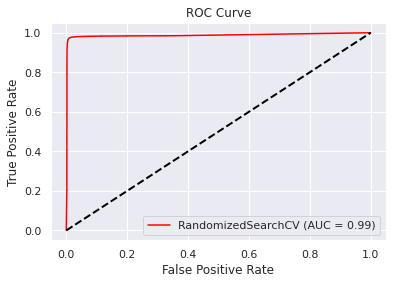

In [31]:
fig= plt.figure( figsize=(10,10) )
plot_roc_curve( search, dataset_test.drop( drop_columns ,axis=1),y_test_, color = 'red',sample_weight = dataset_test.Weight*Norm_Test)
plt.title("ROC Curve")
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
#plt.style.use(hep.style.CMS)
#hep.cms.cmslabel(data=False, paper=False, year='$18.34 fb^{-1}$')
plt.show()
#plt.savefig('/home/matheus/test/roc_normalized.png')
plt.close()

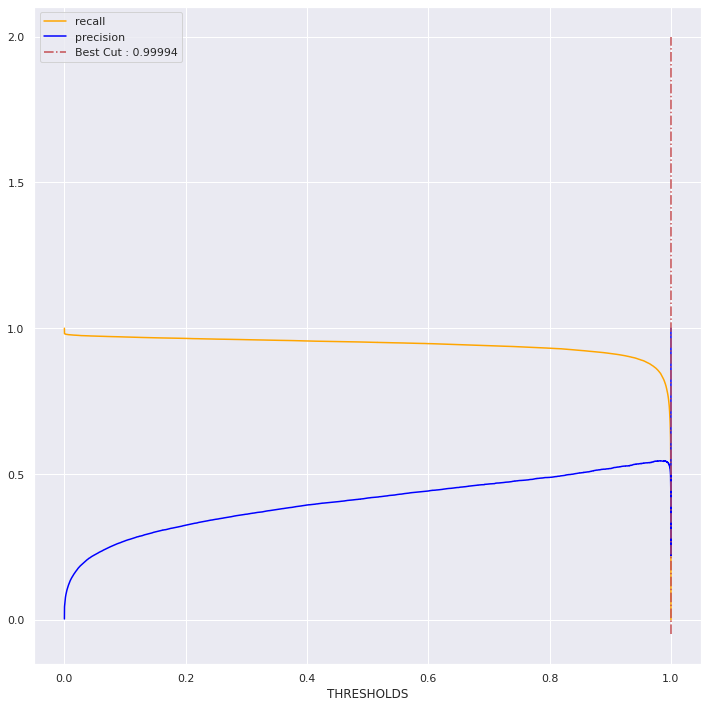

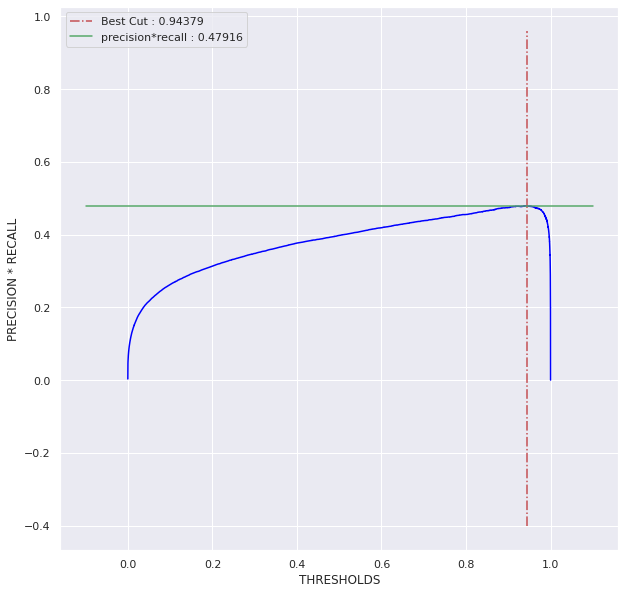

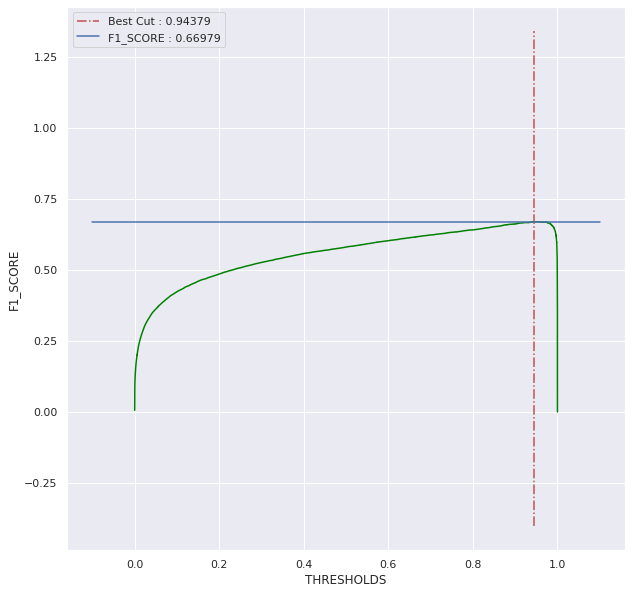

In [32]:
fig= plt.figure( figsize=(10,10) )

best_cut_ = float(threshs[np.argwhere(np.diff(np.sign(rec - prec))).flatten()])

plt.plot( threshs ,rec , color = 'orange' , label = 'recall' )
plt.plot( threshs ,prec ,  color = 'blue' , label = 'precision' )
plt.plot( [ best_cut_,best_cut_ ] , [-0.05,(prec).max()*2] ,"-.r",label='Best Cut : {:2.5f}'.format(best_cut_) )
#plt.ylim(-0.03,1.05)
plt.xlabel(  'THRESHOLDS' )
plt.legend(loc="best")
plt.tight_layout()
plt.show()
plt.close()

fig= plt.figure( figsize=(10,10) )
plt.plot( threshs , prec*rec ,  color = 'blue' )
plt.plot( [ best_cut,best_cut ] , [-0.4,(prec * rec).max()*2] ,"-.r",label='Best Cut : {:2.5f}'.format(best_cut) )
plt.plot( [-0.1,1.1] , [ (prec*rec).max(),(prec*rec).max()], "-g",label='precision*recall : {:2.5f}'.format((prec*rec).max()) )
plt.ylabel( 'PRECISION * RECALL' )
plt.xlabel(    'THRESHOLDS'    )
#plt.ylim( -0.002 , 0.105 )
#plt.xlim( -0.01 , 1.05)
plt.legend(loc="best")
#plt.style.use(hep.style.CMS)
#hep.cms.cmslabel(data=False, paper=False, year='$18.34 fb^{-1}$')
plt.show()
#plt.savefig('/home/matheus/test/prec_rec_normalized.png')
plt.close()

fig= plt.figure( figsize=(10,10) )
plt.plot( threshs , f1 ,  color = 'green' )
plt.plot( [ best_cut,best_cut ] , [-0.4,(f1).max()*2] ,"-.r",label='Best Cut : {:2.5f}'.format(best_cut) )
plt.plot( [-0.1,1.1] , [ (f1).max(),(f1).max()], "-b",label='F1_SCORE : {:2.5f}'.format((f1).max()) )
plt.ylabel(  'F1_SCORE'  )
plt.xlabel( 'THRESHOLDS' )
#plt.ylim( -0.002 , 0.35 )
#plt.xlim( -0.01 , 1.05)
plt.legend(loc="best")
#plt.style.use(hep.style.CMS)
#hep.cms.cmslabel(data=False, paper=False, year='$18.34 fb^{-1}$')
plt.show()
#plt.savefig('/home/matheus/test/f1_normalized.png')
plt.close()

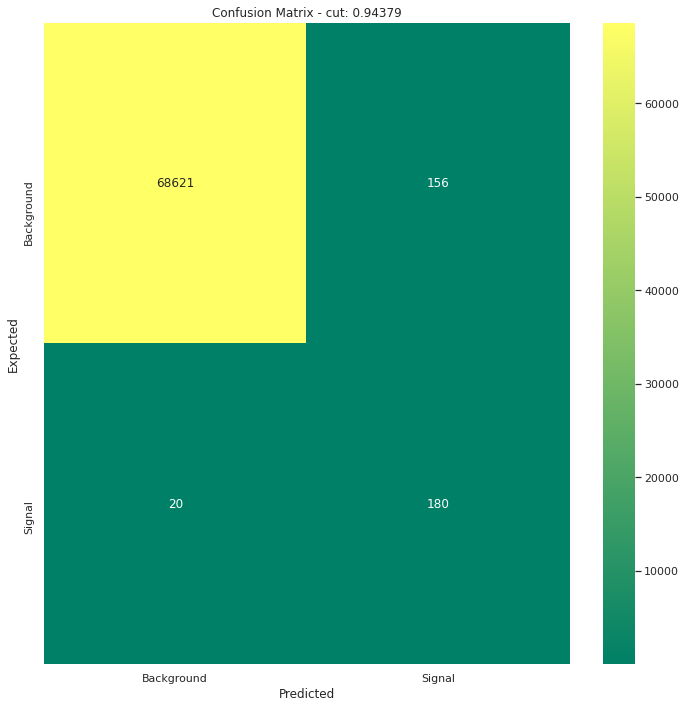

In [33]:
fig= plt.figure( figsize=(10,10) )

confu_matrix = confusion_matrix( y_test_ , y_pred_cut , sample_weight = dataset_test.Weight*Norm_Test )
confu_matrix_DY = ((DataFrame(confu_matrix[0,:]).T).rename(columns = {0: 'Background', 1: 'Signal'}).T).rename(columns = {0: 'Background'}).T
confu_matrix_sig = ((DataFrame(confu_matrix[1,:]).T).rename(columns = {0: 'Background', 1: 'Signal'}).T).rename(columns = {0:'Signal'}).T
cunfusion_matrix = pd.concat([confu_matrix_DY,confu_matrix_sig],axis=0)
sns.heatmap(cunfusion_matrix.astype('int'), annot=True, fmt="d", cmap = 'summer')
plt.title('Confusion Matrix - cut: {:2.5f}'.format(best_cut) )
plt.xlabel('Predicted')
plt.ylabel('Expected')
#hep.cms.cmslabel(data=False, paper=False, year='$18.34 fb^{-1}$')
plt.tight_layout()
plt.show()
#plt.savefig('/home/matheus/test/matrix_normalized.png')
plt.close() 

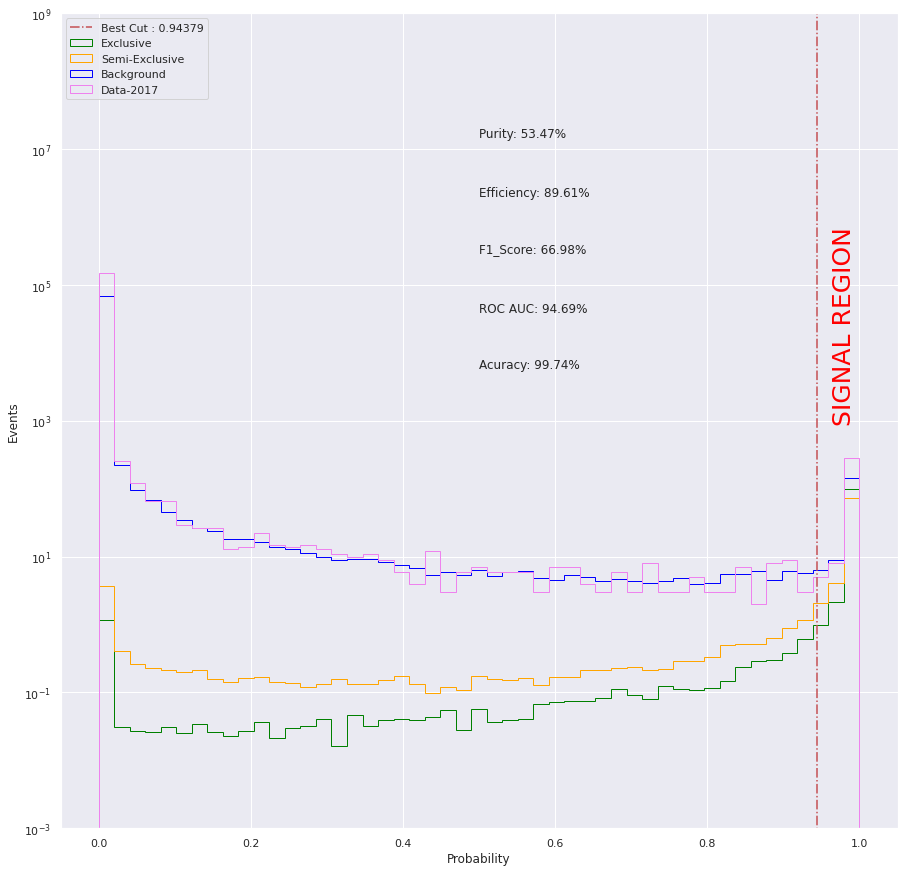

In [34]:
fig= plt.figure( figsize=(15,15) )

hist_Exclu = plt.hist(predict_proba_LGBM_exclusivo, bins=np.linspace(0,1,50), histtype='step', color = 'green', label='Exclusive', weights = MonteCarlo_Exclusive[ 'Weight' ]*Norm_Test)
hist_SemiExclu = plt.hist(predict_proba_LGBM_semiexclusivo, bins=np.linspace(0,1,50), histtype='step',color = 'orange',label='Semi-Exclusive',  weights = MonteCarlo_SemiExclusive[ 'Weight' ]*Norm_Test )
hist_DY = plt.hist(predict_proba_LGBM_background, bins=np.linspace(0,1,50), histtype='step',label='Background', color = 'blue', weights = MonteCarlo_DrellYan[ 'Weight' ]*Norm_Test )
hist_Data = plt.hist(predict_proba_LGBM_Data, bins=np.linspace(0,1,50), histtype='step',label='Data-2017', color = 'violet' )
plt.plot([best_cut,best_cut],[0,10e10],"-.r",label='Best Cut : {:2.5f}'.format(best_cut))
plt.yscale('log')
plt.ylim(10e-4,10e8)
plt.xlabel("Probability")
plt.ylabel("Events")
plt.legend(loc="upper left")
plt.text(best_cut+0.02,10e2, 'SIGNAL REGION', color = 'red', rotation = 90, fontsize = 25)
plt.text(0.5,15e6, "Purity: {:2.2f}%".format(100*precision_score(y_test_,y_pred_cut, sample_weight = dataset_test.Weight*Norm_Test)),fontsize = 12)
plt.text(0.5,20e5, "Efficiency: {:2.2f}%".format(100*recall_score(y_test_,y_pred_cut, sample_weight = dataset_test.Weight*Norm_Test)),fontsize = 12)
plt.text(0.5,30e4, "F1_Score: {:2.2f}%".format(100*f1_score(y_test_,y_pred_cut, sample_weight = dataset_test.Weight*Norm_Test)),fontsize = 12)
plt.text(0.5,40e3, "ROC AUC: {:2.2f}%".format(100*roc_auc_score(y_test_,y_pred_cut, sample_weight = dataset_test.Weight*Norm_Test)),fontsize = 12)
plt.text(0.5,60e2, "Acuracy: {:2.2f}%".format(100*accuracy_score(y_test_,y_pred_cut, sample_weight = dataset_test.Weight*Norm_Test)),fontsize = 12)
#hep.cms.cmslabel(data=False, paper=False, year='$18.34 fb^{-1}$')
#plt.style.use(hep.style.CMS)
plt.show()
plt.tight_layout()
#plt.savefig('/home/matheus/test/discrimante_normalized.png')
plt.close()


In [35]:
class_pred_DY = predict_proba_LGBM_background >= best_cut
class_pred_Exclusive = predict_proba_LGBM_exclusivo >= best_cut
class_pred_SemiExclusive = predict_proba_LGBM_semiexclusivo >= best_cut
class_pred_Data = predict_proba_LGBM_Data >= best_cut

MonteCarlo_Exclusive['target'] = DataFrame((map(int, class_pred_Exclusive)))
MonteCarlo_SemiExclusive['target'] = DataFrame((map(int, class_pred_SemiExclusive)))
MonteCarlo_DrellYan['target'] = DataFrame((map(int, class_pred_DY)))
df_data['target'] = DataFrame((map(int, class_pred_Data)))

events_select_DY = MonteCarlo_DrellYan.loc[MonteCarlo_DrellYan['target'] == 1]
events_select_exclusive = MonteCarlo_Exclusive.loc[MonteCarlo_Exclusive['target'] == 1]
events_select_semiexclu = MonteCarlo_SemiExclusive.loc[MonteCarlo_SemiExclusive['target'] == 1]
events_select_Data = df_data.loc[df_data['target'] == 1]

print('# eventos Data-Drive Background', (events_select_DY['Weight']*Norm_Test).sum())
print('# eventos Semi-Exclusive', (events_select_semiexclu['Weight']*Norm_Test).sum())
print('# eventos Exclusivo', (events_select_exclusive['Weight']*Norm_Test).sum())
print('# eventos Data', len(events_select_Data))
events_select = pd.concat([events_select_DY,events_select_exclusive,events_select_semiexclu],axis=0)

# eventos Data-Drive Background 157.0
# eventos Semi-Exclusive 77.67316753690702
# eventos Exclusivo 102.7500884776646
# eventos Data 279


In [36]:
with h5py.File( '/content/gdrive/My Drive/pps_ML/data_after_train' + '.h5', 'w') as f:
    dset = f.create_dataset( 'data_after', data=events_select_Data )
with h5py.File( '/content/gdrive/My Drive/pps_ML/exclus_after_train' + '.h5', 'w') as f:
    dset = f.create_dataset( 'exclu_after', data=events_select_exclusive )
with h5py.File( '/content/gdrive/My Drive/pps_ML/semiexlu_after_train' + '.h5', 'w') as f:
    dset = f.create_dataset( 'semiexc_after', data=events_select_semiexclu )
with h5py.File( '/content/gdrive/My Drive/pps_ML/backgr_after_train' + '.h5', 'w') as f:
    dset = f.create_dataset( 'back_after', data=events_select_DY )            


Text(0, 0.5, '$\\xi_{\\mu\\mu}$')

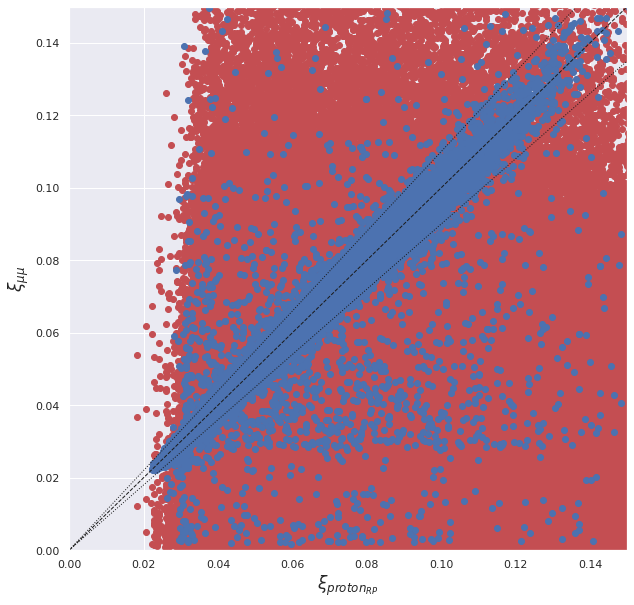

In [37]:
fig= plt.figure( figsize=(10,10) )

msk_bkg = ( y_pred_cut == 0 )
msk_sig = ( y_pred_cut == 1 )

plt.plot( dataset_test[ "Xi" ][ msk_bkg ], dataset_test[ "XiMuMu" ][ msk_bkg ], 'ro' )
plt.plot( dataset_test[ "Xi" ][ msk_sig ], dataset_test[ "XiMuMu" ][ msk_sig ], 'bo' )
plt.plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
plt.plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
plt.plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
plt.xlim(0.,0.15)
plt.ylim(0.,0.15)
plt.xlabel(r'$\xi_{proton_{RP}}$', fontsize=17)
plt.ylabel(r'$\xi_{\mu\mu}$', fontsize=17)

In [38]:
y_sig_pred = np.concatenate([class_pred_Exclusive,class_pred_SemiExclusive])
y_bkg_pred = class_pred_DY

In [39]:
MonteCarlo_Signal = pd.concat([MonteCarlo_Exclusive,MonteCarlo_SemiExclusive])

Text(0, 0.5, '$\\xi_{\\mu^{-}}$')

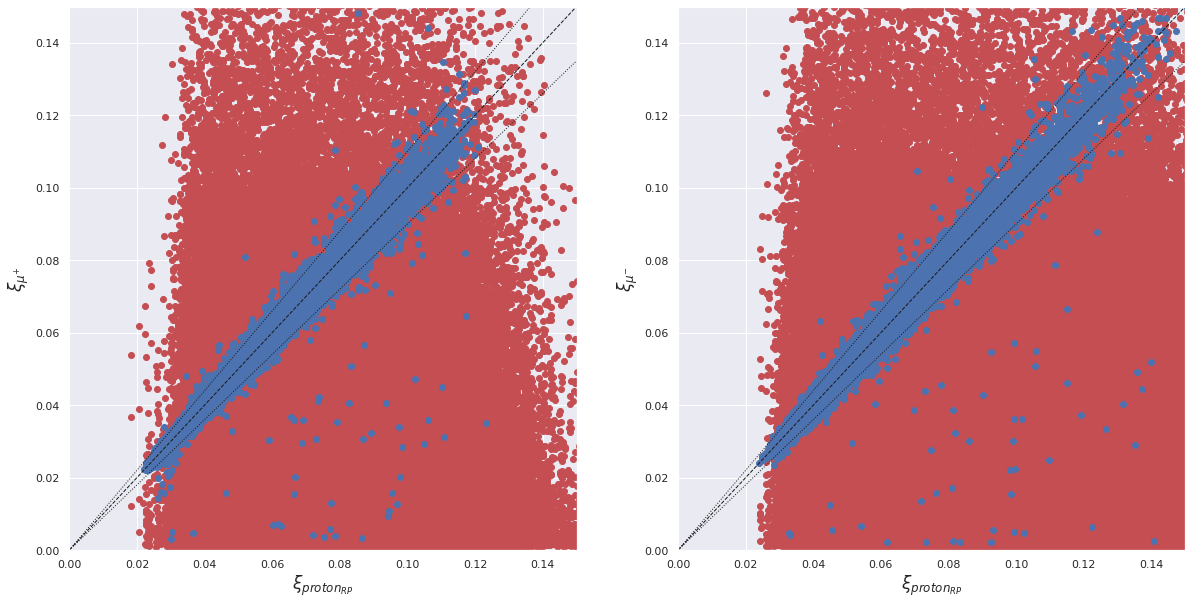

In [40]:
fig, axes = plt.subplots( 1, 2, figsize=(20,10) )

msk_bkg_1 = None
msk_bkg_2 = None
msk_sig_1 = None
msk_sig_2 = None
if proton_selection == "SingleRP":
    msk_bkg_1 = ( MonteCarlo_DrellYan[ "RPId1" ] == 23 ) & ( y_bkg_pred == 0 )
    msk_bkg_2 = ( MonteCarlo_DrellYan[ "RPId1" ] == 123 ) & ( y_bkg_pred == 0 )
    msk_sig_1 = ( MonteCarlo_Signal[ "RPId1" ] == 23 ) & ( y_sig_pred == 1 )
    msk_sig_2 = ( MonteCarlo_Signal[ "RPId1" ] == 123 ) & ( y_sig_pred == 1 )
elif proton_selection == "MultiRP":
    msk_bkg_1 = ( MonteCarlo_DrellYan[ "Arm" ] == 0 ) & ( y_bkg_pred == 0 )
    msk_bkg_2 = ( MonteCarlo_DrellYan[ "Arm" ] == 1 ) & ( y_bkg_pred == 0 )
    msk_sig_1 = ( MonteCarlo_Signal[ "Arm" ] == 0 ) & ( y_sig_pred == 1 )
    msk_sig_2 = ( MonteCarlo_Signal[ "Arm" ] == 1 ) & ( y_sig_pred == 1 )
    
axes[0].plot( MonteCarlo_DrellYan[ "Xi" ][ msk_bkg_1 ], MonteCarlo_DrellYan[ "XiMuMuPlus" ][ msk_bkg_1 ], 'ro' )
axes[0].plot( MonteCarlo_Signal[ "Xi" ][ msk_sig_1 ], MonteCarlo_Signal[ "XiMuMuPlus" ][ msk_sig_1 ], 'bo' )
axes[0].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[0].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[0].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[0].set_xlim(0.,0.15)
axes[0].set_ylim(0.,0.15)
axes[0].set_xlabel(r'$\xi_{proton_{RP}}$', fontsize=17)
axes[0].set_ylabel(r'$\xi_{\mu^{+}}$', fontsize=17)

axes[1].plot( MonteCarlo_DrellYan[ "Xi" ][ msk_bkg_2 ], MonteCarlo_DrellYan[ "XiMuMuMinus" ][ msk_bkg_2 ], 'ro' )
axes[1].plot( MonteCarlo_Signal[ "Xi" ][ msk_sig_2 ], MonteCarlo_Signal[ "XiMuMuMinus" ][ msk_sig_2 ], 'bo' )
axes[1].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[1].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[1].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[1].set_xlim(0.,0.15)
axes[1].set_ylim(0.,0.15)
axes[1].set_xlabel(r'$\xi_{proton_{RP}}$', fontsize=17)
axes[1].set_ylabel(r'$\xi_{\mu^{-}}$', fontsize=17)


(0.0, 0.15)

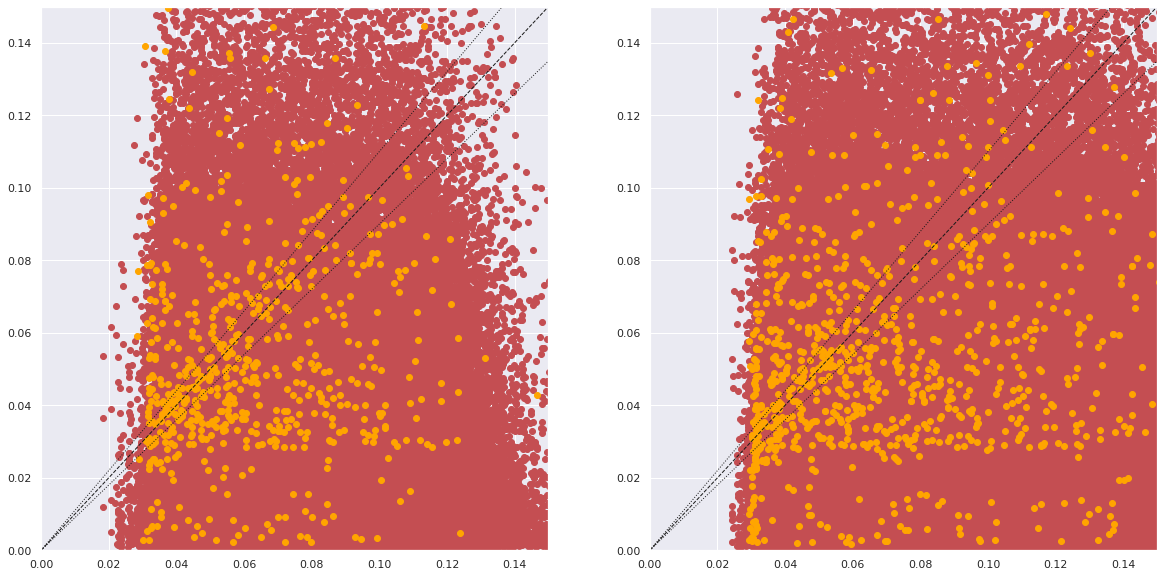

In [41]:
fig, axes = plt.subplots( 1, 2, figsize=(20,10) )

msk_bkg_1 = None
msk_bkg_2 = None
msk_bkgerr_1 = None
msk_bkgerr_2 = None
if proton_selection == "SingleRP":
    msk_bkg_1 = ( MonteCarlo_DrellYan[ "RPId1" ] == 23 ) & ( y_bkg_pred == 0 )
    msk_bkg_2 = ( MonteCarlo_DrellYan[ "RPId1" ] == 123 ) & ( y_bkg_pred == 0 )
    msk_bkgerr_1 = ( MonteCarlo_DrellYan[ "RPId1" ] == 23 ) & ( y_bkg_pred == 1 )
    msk_bkgerr_2 = ( MonteCarlo_DrellYan[ "RPId1" ] == 123 ) & ( y_bkg_pred == 1 )
elif proton_selection == "MultiRP":
    msk_bkg_1 = ( MonteCarlo_DrellYan[ "Arm" ] == 0 ) & ( y_bkg_pred == 0 )
    msk_bkg_2 = ( MonteCarlo_DrellYan[ "Arm" ] == 1 ) & ( y_bkg_pred == 0 )
    msk_bkgerr_1 = ( MonteCarlo_DrellYan[ "Arm" ] == 0 ) & ( y_bkg_pred == 1 )
    msk_bkgerr_2 = ( MonteCarlo_DrellYan[ "Arm" ] == 1 ) & ( y_bkg_pred == 1 )
    
axes[0].plot( MonteCarlo_DrellYan[ "Xi" ][ msk_bkg_1 ], MonteCarlo_DrellYan[ "XiMuMuPlus" ][ msk_bkg_1 ], 'ro' )
axes[0].plot( MonteCarlo_DrellYan[ "Xi" ][ msk_bkgerr_1 ], MonteCarlo_DrellYan[ "XiMuMuPlus" ][ msk_bkgerr_1 ], 'o', color='orange' )
axes[0].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[0].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[0].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[0].set_xlim(0.,0.15)
axes[0].set_ylim(0.,0.15)

axes[1].plot( MonteCarlo_DrellYan[ "Xi" ][ msk_bkg_2 ], MonteCarlo_DrellYan[ "XiMuMuMinus" ][ msk_bkg_2 ], 'ro' )
axes[1].plot( MonteCarlo_DrellYan[ "Xi" ][ msk_bkgerr_2 ], MonteCarlo_DrellYan[ "XiMuMuMinus" ][ msk_bkgerr_2 ], 'o', color='orange' )
axes[1].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[1].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[1].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[1].set_xlim(0.,0.15)
axes[1].set_ylim(0.,0.15)

(0.0, 0.15)

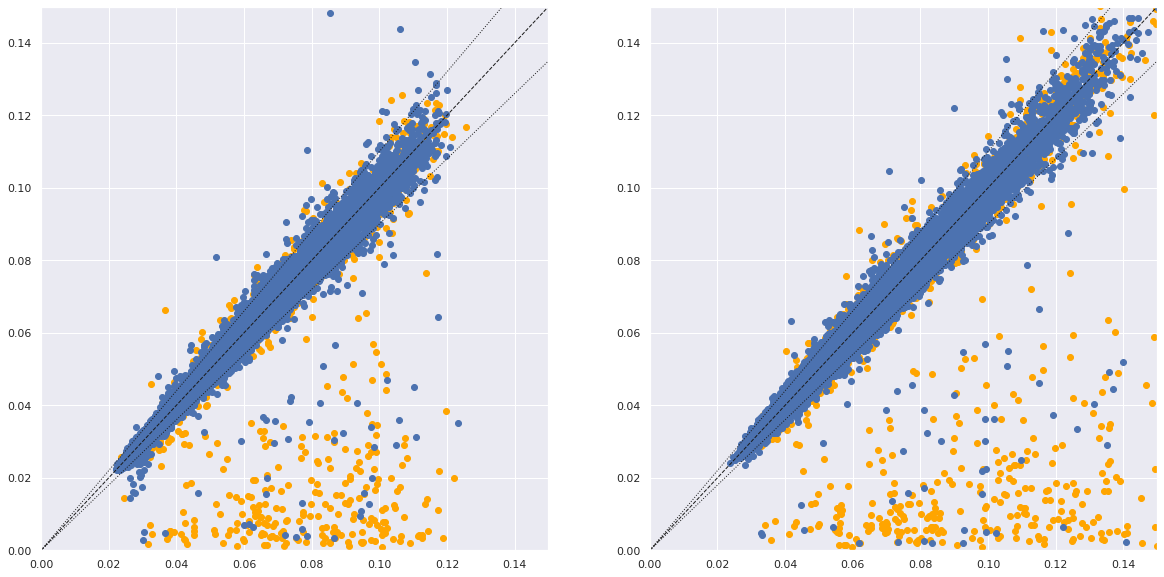

In [42]:
fig, axes = plt.subplots( 1, 2, figsize=(20,10) )

msk_sigerr_1 = None
msk_sigerr_2 = None
msk_sig_1 = None
msk_sig_2 = None
if proton_selection == "SingleRP":
    msk_sigerr_1 = ( MonteCarlo_Signal[ "RPId1" ] == 23 ) & ( y_sig_pred == 0 )
    msk_sigerr_2 = ( MonteCarlo_Signal[ "RPId1" ] == 123 ) & ( y_sig_pred == 0 )
    msk_sig_1 = ( MonteCarlo_Signal[ "RPId1" ] == 23 ) & ( y_sig_pred == 1 )
    msk_sig_2 = ( MonteCarlo_Signal[ "RPId1" ] == 123 ) & ( y_sig_pred == 1 )
elif proton_selection == "MultiRP":
    msk_sigerr_1 = ( MonteCarlo_Signal[ "Arm" ] == 0 ) & ( y_sig_pred == 0 )
    msk_sigerr_2 = ( MonteCarlo_Signal[ "Arm" ] == 1 ) & ( y_sig_pred == 0 )
    msk_sig_1 = ( MonteCarlo_Signal[ "Arm" ] == 0 ) & ( y_sig_pred == 1 )
    msk_sig_2 = ( MonteCarlo_Signal[ "Arm" ] == 1 ) & ( y_sig_pred == 1 )

axes[0].plot( MonteCarlo_Signal[ "Xi" ][ msk_sigerr_1 ], MonteCarlo_Signal[ "XiMuMuPlus" ][ msk_sigerr_1 ], 'o', color='orange' )
axes[0].plot( MonteCarlo_Signal[ "Xi" ][ msk_sig_1 ], MonteCarlo_Signal[ "XiMuMuPlus" ][ msk_sig_1 ], 'bo' )
axes[0].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[0].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[0].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[0].set_xlim(0.,0.15)
axes[0].set_ylim(0.,0.15)
axes[1].plot( MonteCarlo_Signal[ "Xi" ][ msk_sigerr_2 ], MonteCarlo_Signal[ "XiMuMuMinus" ][ msk_sigerr_2 ], 'o', color='orange' )
axes[1].plot( MonteCarlo_Signal[ "Xi" ][ msk_sig_2 ], MonteCarlo_Signal[ "XiMuMuMinus" ][ msk_sig_2 ], 'bo' )
axes[1].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[1].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[1].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[1].set_xlim(0.,0.15)
axes[1].set_ylim(0.,0.15)

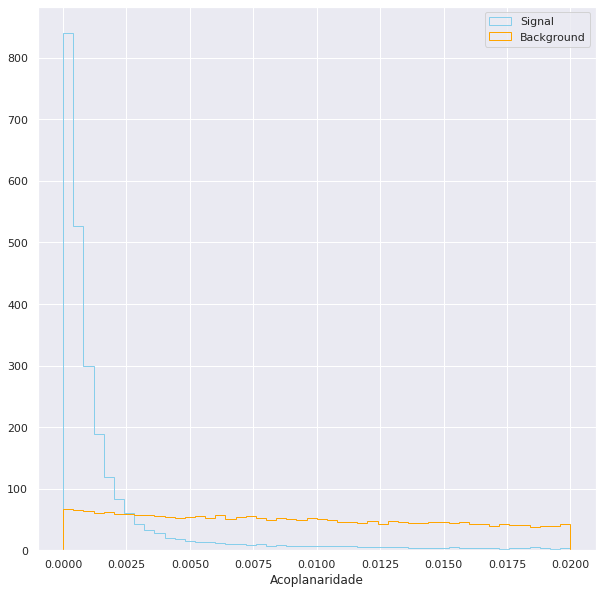

In [43]:
fig = plt.figure( figsize=(10,10) )
plt.hist( dataset_test[ "Acopl" ][ y_pred_cut == 1 ], histtype='step', color='skyblue', bins=50, range=(0.,0.02), density=True, label="Signal" )
plt.hist( dataset_test[ "Acopl" ][ y_pred_cut == 0 ], histtype='step', color='orange', bins=50, range=(0.,0.02), density=True, label="Background" )
plt.xlabel('Acoplanaridade')
plt.legend(loc="best")

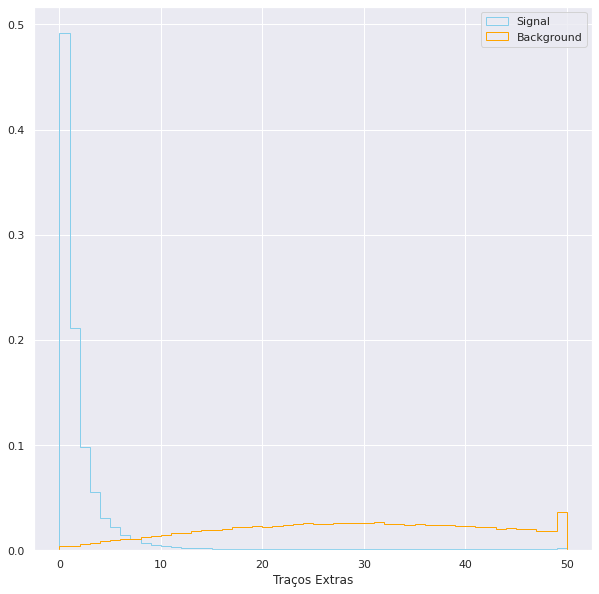

In [44]:
fig = plt.figure( figsize=(10,10) )
plt.hist( dataset_test[ "ExtraPfCands" ][ y_pred_cut == 1 ], histtype='step', color='skyblue', bins=50, range=(0,50), density=True, label="Signal" )
plt.hist( dataset_test[ "ExtraPfCands" ][ y_pred_cut == 0 ], histtype='step', color='orange', bins=50, range=(0,50), density=True,label="Background" )
plt.xlabel('Traços Extras')
plt.legend(loc="best")

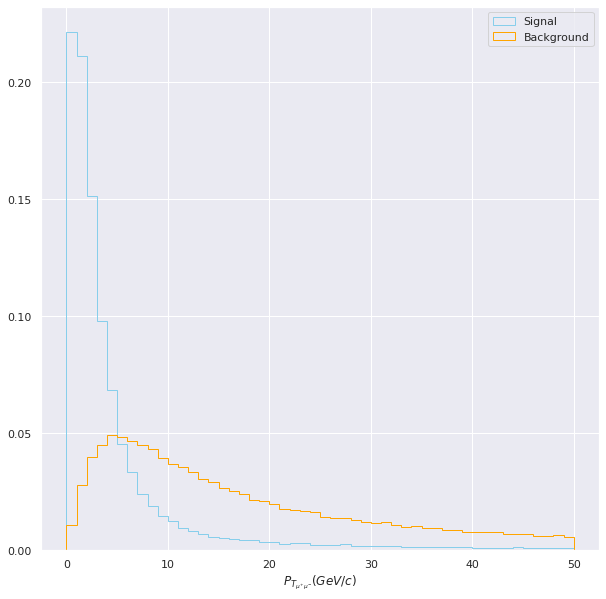

In [45]:
fig = plt.figure( figsize=(10,10) )
plt.hist( dataset_test[ "pt" ][ y_pred_cut == 1 ], histtype='step', color='skyblue', bins=50, range=(0,50), density=True, label='Signal' )
plt.hist( dataset_test[ "pt" ][ y_pred_cut == 0 ], histtype='step', color='orange', bins=50, range=(0,50), density=True, label="Background" )
plt.xlabel("$P_{T_{\mu^{+}\mu^{-}}}(GeV/c)$")
plt.legend(loc="best")

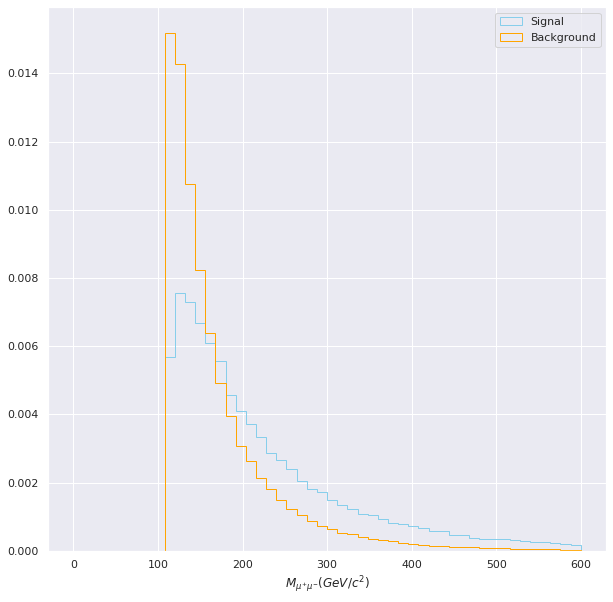

In [46]:
fig = plt.figure( figsize=(10,10) )
plt.hist( dataset_test[ "InvMass" ][ y_pred_cut == 1 ], histtype='step', color='skyblue', bins=50, range=(0,600), density=True, label='Signal' )
plt.hist( dataset_test[ "InvMass" ][ y_pred_cut == 0 ], histtype='step', color='orange', bins=50, range=(0,600), density=True,label="Background" )
plt.xlabel("$M_{\mu^{+}\mu^{-}}(GeV/c^{2})$")
plt.legend(loc="best")

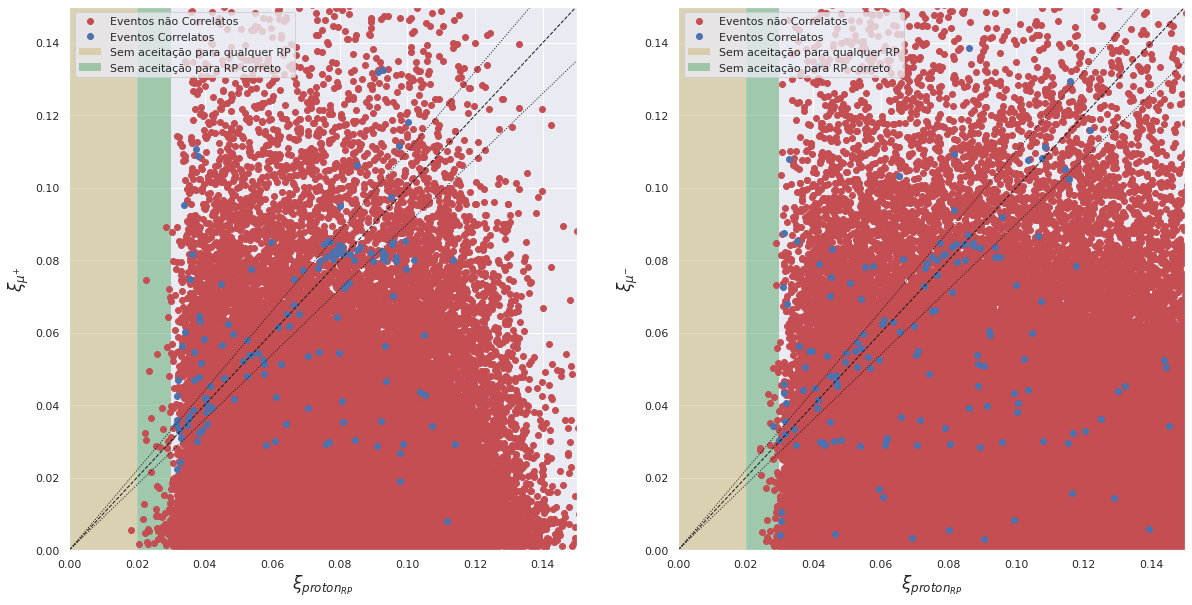

In [47]:
fig, axes = plt.subplots( 1, 2, figsize=(20,10) )

msk_bkg_1 = None
msk_bkg_2 = None
msk_sig_1 = None
msk_sig_2 = None
if proton_selection == "SingleRP":
    msk_bkg_1 = ( df_data[ "RPId1" ] == 23 ) & ( y_data == 0 )
    msk_bkg_2 = ( df_data[ "RPId1" ] == 123 ) & ( y_data == 0 )
    msk_sig_1 = ( df_data[ "RPId1" ] == 23 ) & ( y_data == 1 )
    msk_sig_2 = ( df_data[ "RPId1" ] == 123 ) & ( y_data == 1 )
elif proton_selection == "MultiRP":
    msk_bkg_1 = ( df_data[ "Arm" ] == 0 ) & ( class_pred_Data == 0 )
    msk_bkg_2 = ( df_data[ "Arm" ] == 1 ) & ( class_pred_Data == 0 )
    msk_sig_1 = ( df_data[ "Arm" ] == 0 ) & ( class_pred_Data == 1 )
    msk_sig_2 = ( df_data[ "Arm" ] == 1 ) & ( class_pred_Data == 1 )

axes[0].plot( df_data[ "Xi" ][ msk_bkg_1 ], df_data[ "XiMuMuPlus" ][ msk_bkg_1 ], 'ro', label="Eventos não Correlatos" )
axes[0].plot( df_data[ "Xi" ][ msk_sig_1 ], df_data[ "XiMuMuPlus" ][ msk_sig_1 ], 'bo',label="Eventos Correlatos" )
axes[0].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[0].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[0].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[0].set_xlim(0.,0.15)
axes[0].set_ylim(0.,0.15)
axes[0].set_xlabel(r'$\xi_{proton_{RP}}$', fontsize=17)
axes[0].set_ylabel(r'$\xi_{\mu^{+}}$', fontsize=17)
axes[0].axvspan(0, 0.02, color='y', alpha=0.5, lw=0, label="Sem aceitação para qualquer RP")
axes[0].axvspan(0.02, 0.03, color='g', alpha=0.5, lw=0, label="Sem aceitação para RP correto")
axes[0].legend(loc="upper left")

axes[1].plot( df_data[ "Xi" ][ msk_bkg_2 ], df_data[ "XiMuMuMinus" ][ msk_bkg_2 ], 'ro', label="Eventos não Correlatos" )
axes[1].plot( df_data[ "Xi" ][ msk_sig_2 ], df_data[ "XiMuMuMinus" ][ msk_sig_2 ], 'bo', label="Eventos Correlatos" )
axes[1].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[1].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[1].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[1].set_xlim(0.,0.15)
axes[1].set_ylim(0.,0.15)
axes[1].set_xlabel(r'$\xi_{proton_{RP}}$', fontsize=17)
axes[1].set_ylabel(r'$\xi_{\mu^{-}}$', fontsize=17)
axes[1].axvspan(0, 0.02, color='y', alpha=0.5, lw=0, label="Sem aceitação para qualquer RP")
axes[1].axvspan(0.02, 0.03, color='g', alpha=0.5, lw=0,  label="Sem aceitação para RP correto")
axes[1].legend(loc="best")


(array([56.24207858, 60.54227775, 61.3344197 , 57.48687308, 58.27901503,
        56.9210574 , 60.88176716, 52.05504255, 52.73402137, 60.76860402,
        53.97881586, 53.29983705, 53.63932645, 50.92341119, 57.37370994,
        58.27901503, 55.78942604, 54.54463154, 52.62085823, 50.69708492,
        55.11044722, 54.4314684 , 47.86800652, 50.35759551, 55.22361036,
        51.14973746, 48.4338222 , 46.73637516, 45.71790693, 45.37841753,
        51.03657433, 42.43617599, 47.41535397, 47.41535397, 42.32301286,
        44.24678617, 48.99963788, 47.1890277 , 45.94423321, 45.94423321,
        42.32301286, 43.56780735, 39.60709759, 43.90729676, 42.88882854,
        41.41770777, 42.88882854, 40.28607641, 42.20984972, 39.15444505]),
 array([0.    , 0.0004, 0.0008, 0.0012, 0.0016, 0.002 , 0.0024, 0.0028,
        0.0032, 0.0036, 0.004 , 0.0044, 0.0048, 0.0052, 0.0056, 0.006 ,
        0.0064, 0.0068, 0.0072, 0.0076, 0.008 , 0.0084, 0.0088, 0.0092,
        0.0096, 0.01  , 0.0104, 0.0108, 0.0112, 0.01

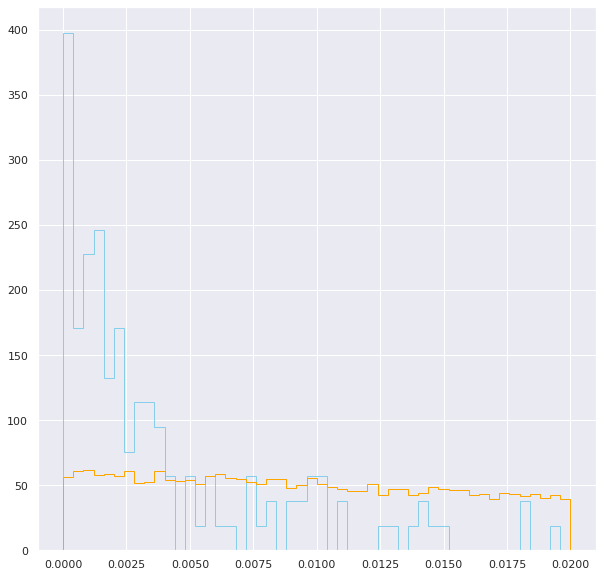

In [49]:
fig = plt.figure( figsize=(10,10) )
plt.hist( df_data[ "Acopl" ][ class_pred_Data == 1 ], histtype='step', color='skyblue', bins=50, range=(0.,0.02), density=True )
plt.hist( df_data[ "Acopl" ][ class_pred_Data == 0 ], histtype='step', color='orange', bins=50, range=(0.,0.02), density=True )

(array([0.00152566, 0.00249386, 0.00358921, 0.00460631, 0.00605373,
        0.00711973, 0.00736423, 0.00729577, 0.00862583, 0.01012215,
        0.01038621, 0.01131529, 0.01302677, 0.01425903, 0.01510988,
        0.01599006, 0.0176722 , 0.01833723, 0.01861106, 0.01979443,
        0.0201465 , 0.02213181, 0.02152546, 0.02333474, 0.02450832,
        0.02460612, 0.02611221, 0.02507555, 0.02581882, 0.02719778,
        0.02643495, 0.02795083, 0.02784325, 0.02769655, 0.02702174,
        0.02870388, 0.02776501, 0.02756941, 0.02710976, 0.02690438,
        0.02756941, 0.02550586, 0.0254374 , 0.02502665, 0.02541784,
        0.02459634, 0.02530049, 0.02354011, 0.02359879, 0.04525139]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.]),
 <a list of 1 Patch objects>)

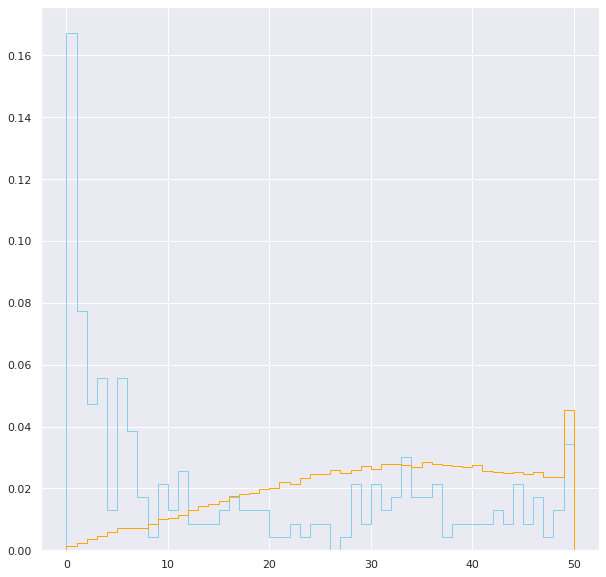

In [50]:
fig = plt.figure( figsize=(10,10) )
plt.hist( df_data[ "ExtraPfCands" ][ class_pred_Data == 1 ], histtype='step', color='skyblue', bins=50, range=(0,50), density=True )
plt.hist( df_data[ "ExtraPfCands" ][ class_pred_Data == 0 ], histtype='step', color='orange', bins=50, range=(0,50), density=True )

(array([0.20742713, 0.11466193, 0.08862258, 0.12782956, 0.01479509,
        0.01435124, 0.01035656, 0.01109632, 0.01346353, 0.0252996 ,
        0.02145288, 0.01168812, 0.01065246, 0.01020861, 0.00917295,
        0.00932091, 0.00932091, 0.01227992, 0.009025  , 0.00932091,
        0.01020861, 0.00739754, 0.01183607, 0.00887705, 0.0087291 ,
        0.01006066, 0.009025  , 0.00769345, 0.00769345, 0.009025  ,
        0.00769345, 0.00754549, 0.00665779, 0.00665779, 0.00724959,
        0.00932091, 0.00739754, 0.01154017, 0.00932091, 0.01154017,
        0.00932091, 0.00739754, 0.0084332 , 0.0078414 , 0.00680574,
        0.0081373 , 0.00858115, 0.0087291 , 0.01035656, 0.00858115]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.]),
 <a list of 1 Patch objects>)

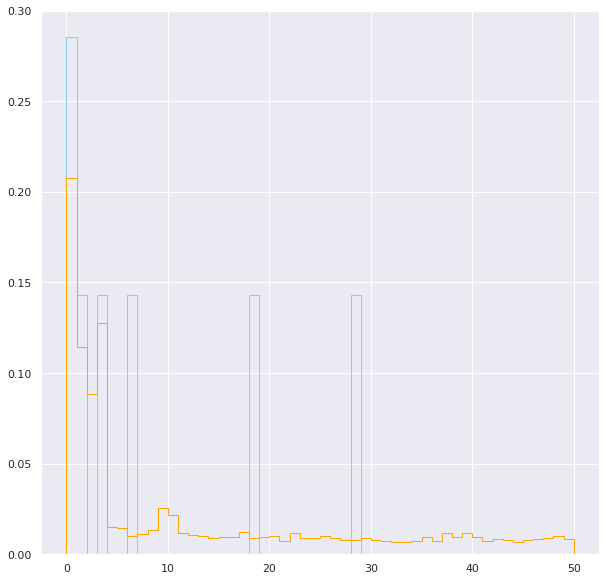

In [51]:
fig = plt.figure( figsize=(10,10) )
plt.hist( df_data[ "InvMass" ][ class_pred_Data == 1 ], histtype='step', color='skyblue', bins=50, range=(0,50), density=True )
plt.hist( df_data[ "InvMass" ][ class_pred_Data == 0 ], histtype='step', color='orange', bins=50, range=(0,50), density=True )

(array([0.01159736, 0.03190051, 0.0455344 , 0.04973183, 0.05214147,
        0.05069569, 0.04767975, 0.04525457, 0.04076176, 0.03731053,
        0.03574038, 0.0334862 , 0.03050136, 0.0285892 , 0.02691022,
        0.02530898, 0.02324135, 0.02237077, 0.01909056, 0.01929265,
        0.01804897, 0.01703848, 0.01546832, 0.01540614, 0.01570152,
        0.01307423, 0.01293432, 0.01211038, 0.01225029, 0.01186164,
        0.01085115, 0.01176836, 0.00918772, 0.01030703, 0.00980956,
        0.00914108, 0.00876798, 0.00879907, 0.00890789, 0.00862806,
        0.00799067, 0.00808395, 0.0088768 , 0.00816168, 0.00822386,
        0.00864361, 0.00781967, 0.00917217, 0.00781967, 0.00800622]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.]),
 <a list of 1 Patch objects>)

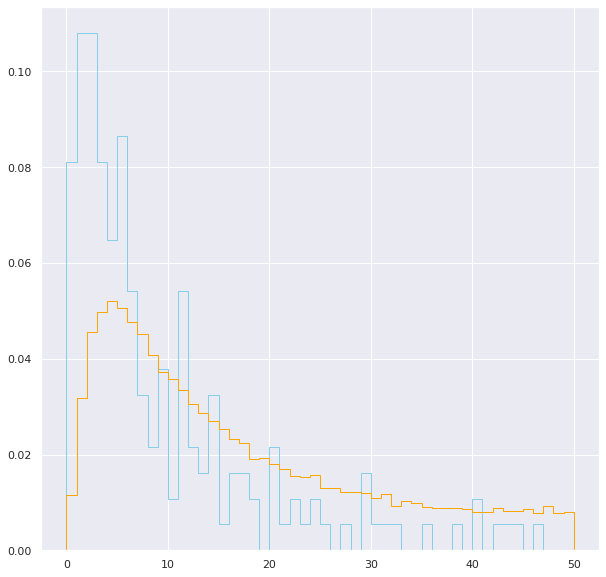

In [52]:
fig = plt.figure( figsize=(10,10) )
plt.hist( df_data[ "pt" ][ class_pred_Data == 1 ], histtype='step', color='skyblue', bins=50, range=(0,50), density=True )
plt.hist( df_data[ "pt" ][ class_pred_Data == 0 ], histtype='step', color='orange', bins=50, range=(0,50), density=True )

y max. = 53.8062484748657


Text(0, 0.5, 'Eventos')

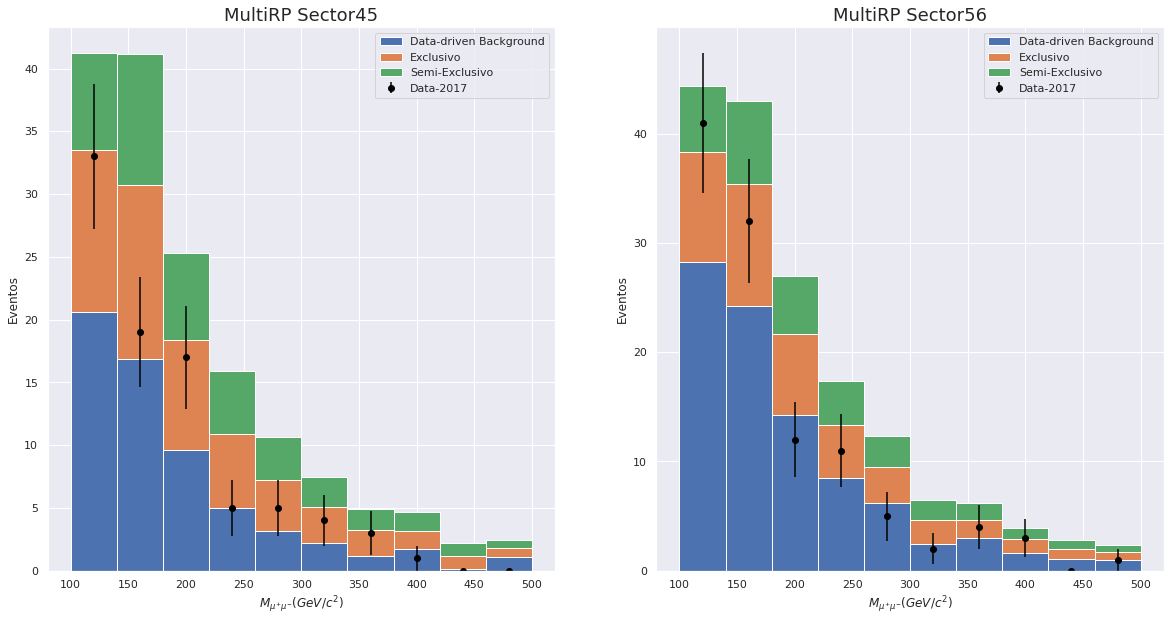

In [53]:
fig, axes = plt.subplots( 1, 2, figsize=(20,10) )

#var_ = "Xi"
#bins_ = 10
#range_ = (0.,0.2)

#var_ = "ThX"
#bins_ = 10
#range_ = (-0.0005,0.0005)

#var_ = "ThY"
#bins_ = 10
#range_ = (-0.0005,0.0005)

#var_ = "T"
#bins_ = 10
#range_ = (-4.,0.)

#var_ = "Time"
#bins_ = 20
#range_ = (-0.5,0.5)

#var_ = "pt"
#bins_ = 10
#range_ = (0.,10.)

var_ = "InvMass"
bins_ = 10
range_ = (100.,500.)

#var_ = "Acopl"
#bins_ = 10
#range_ = (0.,0.01)

#var_ = "ExtraPfCands"
#bins_ = 20
#range_ = (0,20)

msk_data_1 = None
msk_data_2 = None
if proton_selection == "SingleRP":
    msk_data_1 = ( df_data[ "RPId1" ] == 23 ) & ( y_data == 1 )
    msk_data_2 = ( df_data[ "RPId1" ] == 123 ) & ( y_data == 1 )
elif proton_selection == "MultiRP":
    msk_data_1 = ( df_data[ "Arm" ] == 0 ) & ( class_pred_Data == 1 )
    msk_data_2 = ( df_data[ "Arm" ] == 1 ) & ( class_pred_Data == 1 )

counts_1, bin_edges_1 = np.histogram( df_data[ var_ ][ msk_data_1 ], bins=bins_, range=range_ )
errors_1 = np.sqrt( counts_1 )
bin_centres_1 = ( bin_edges_1[:-1] + bin_edges_1[1:] ) / 2.
axes[0].errorbar(bin_centres_1, counts_1, yerr=errors_1, fmt='o', label = 'Data-2017', color = 'black')

counts_2, bin_edges_2 = np.histogram( df_data[ var_ ][ msk_data_2 ], bins=bins_, range=range_)
errors_2 = np.sqrt( counts_2 )
bin_centres_2 = ( bin_edges_2[:-1] + bin_edges_2[1:] ) / 2.
axes[1].errorbar(bin_centres_2, counts_2, yerr=errors_2, fmt='o', label = 'Data-2017', color = 'black')

idx_ymax_ = np.argmax( np.concatenate( [counts_1, counts_2] ) )
y_max = np.concatenate( [counts_1, counts_2] )[idx_ymax_] + 2*np.concatenate( [errors_1, errors_2] )[idx_ymax_]
print ( "y max. = {}".format(y_max) )

msk_bkg_pred_1 = None
msk_bkg_pred_2 = None
if proton_selection == "SingleRP":
    msk_bkg_pred_1 = ( MonteCarlo_DrellYan[ "RPId1" ] == 23 ) & ( y_bkg_pred == 1 )
    msk_sgex_pred_1 = ( MonteCarlo_Exclusive[ "RPId1" ] == 23 ) & ( class_pred_Exclusive == 1 )
    msk_sgsex_pred_1 = ( MonteCarlo_SemiExclusive[ "RPId1" ] == 23 ) & ( class_pred_SemiExclusive == 1 )

    msk_bkg_pred_2 = ( MonteCarlo_DrellYan[ "RPId1" ] == 123 ) & ( y_bkg_pred == 1 )
    msk_sgex_pred_2 = ( MonteCarlo_Exclusive[ "RPId1" ] == 123 ) & ( class_pred_Exclusive == 1 )
    msk_sgsex_pred_2 = ( MonteCarlo_SemiExclusive[ "RPId1" ] == 123 ) & ( class_pred_SemiExclusive == 1 )
elif proton_selection == "MultiRP":
    msk_bkg_pred_1 = ( MonteCarlo_DrellYan[ "Arm" ] == 0 ) & ( y_bkg_pred == 1 )
    msk_sgex_pred_1 = ( MonteCarlo_Exclusive[ "Arm" ] == 0 ) & ( class_pred_Exclusive == 1 )
    msk_sgsex_pred_1 = ( MonteCarlo_SemiExclusive[ "Arm" ] == 0 ) & ( class_pred_SemiExclusive == 1 )

    msk_bkg_pred_2 = ( MonteCarlo_DrellYan[ "Arm" ] == 1 ) & ( y_bkg_pred == 1 )    
    msk_sgex_pred_2 = ( MonteCarlo_Exclusive[ "Arm" ] == 1 ) & ( class_pred_Exclusive == 1 )
    msk_sgsex_pred_2 = ( MonteCarlo_SemiExclusive[ "Arm" ] == 1 ) & ( class_pred_SemiExclusive == 1 )

weights_1_back = None
if resample_factor > 1:
    weights_1_back = np.full_like( MonteCarlo_DrellYan[ "Xi" ][ msk_bkg_pred_1 ], ( 1./resample_factor ) )
weights_1_sgexclu = None
if resample_factor > 1:
    weights_1_sgexclu = np.full_like( MonteCarlo_Exclusive[ "Xi" ][ msk_sgex_pred_1 ], ( 1./resample_factor ) )
weights_1_sgseexlu = None
if resample_factor > 1:
    weights_1_sgseexlu = np.full_like( MonteCarlo_SemiExclusive[ "Xi" ][ msk_sgsex_pred_1 ], ( 1./resample_factor ) )

weights_2_back = None
if resample_factor > 1:
    weights_2_back = np.full_like( MonteCarlo_DrellYan[ "Xi" ][ msk_bkg_pred_2 ], ( 1./resample_factor ) )
weights_2_sgexlu = None
if resample_factor > 1:
    weights_2 = np.full_like( MonteCarlo_Exclusive[ "Xi" ][ msk_sgex_pred_2 ], ( 1./resample_factor ) )
weights_2_sgsemi = None
if resample_factor > 1:
    weights_2 = np.full_like( MonteCarlo_SemiExclusive[ "Xi" ][ msk_sgsex_pred_2 ], ( 1./resample_factor ) )

axes[0].hist( [MonteCarlo_DrellYan[ var_ ][ msk_bkg_pred_1 ] ,
               MonteCarlo_Exclusive[ var_ ][ msk_sgex_pred_1 ],
               MonteCarlo_SemiExclusive[ var_ ][ msk_sgsex_pred_1 ]], stacked = True, bins=bins_, range=range_, weights = [weights_1_back*Norm_Test,
                                                                                                                           MonteCarlo_Exclusive.Weight[ msk_sgex_pred_1 ]*Norm_Test,
                                                                                                                           MonteCarlo_SemiExclusive.Weight[ msk_sgsex_pred_1 ]*Norm_Test], label = ["Data-driven Background","Exclusivo","Semi-Exclusivo"] )
axes[0].legend()
axes[0].set_title("MultiRP Sector45", fontsize=18)
axes[0].set_xlabel("$M_{\mu^{+}\mu^{-}}(GeV/c^{2})$")
axes[0].set_ylabel('Eventos')

axes[1].hist( [MonteCarlo_DrellYan[ var_ ][ msk_bkg_pred_2 ] ,
               MonteCarlo_Exclusive[ var_ ][ msk_sgex_pred_2 ],
               MonteCarlo_SemiExclusive[ var_ ][ msk_sgsex_pred_2 ]], stacked = True, bins=bins_, range=range_, weights = [weights_2_back*Norm_Test,
                                                                                                                           MonteCarlo_Exclusive.Weight[ msk_sgex_pred_2 ]*Norm_Test,
                                                                                                                           MonteCarlo_SemiExclusive.Weight[ msk_sgsex_pred_2 ]*Norm_Test], label = ["Data-driven Background","Exclusivo","Semi-Exclusivo"] )
axes[1].legend()
axes[1].set_title("MultiRP Sector56", fontsize=18)
axes[1].set_xlabel("$M_{\mu^{+}\mu^{-}}(GeV/c^{2})$")
axes[1].set_ylabel('Eventos')


y max. = 18.928203230275507


Text(0, 0.5, 'Eventos')

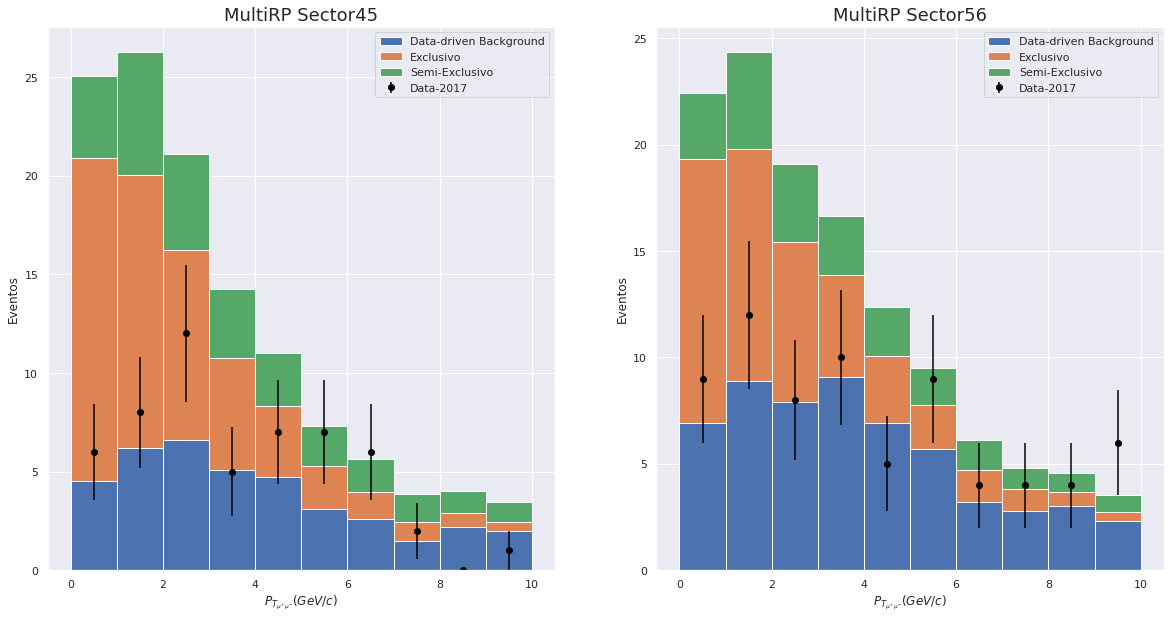

In [54]:
fig, axes = plt.subplots( 1, 2, figsize=(20,10) )

var_ = "pt"
bins_ = 10
range_ = (0.,10.)

counts_1, bin_edges_1 = np.histogram( df_data[ var_ ][ msk_data_1 ], bins=bins_, range=range_ )
errors_1 = np.sqrt( counts_1 )
bin_centres_1 = ( bin_edges_1[:-1] + bin_edges_1[1:] ) / 2.
axes[0].errorbar(bin_centres_1, counts_1, yerr=errors_1, fmt='o', label = 'Data-2017', color = 'black')

counts_2, bin_edges_2 = np.histogram( df_data[ var_ ][ msk_data_2 ], bins=bins_, range=range_ )
errors_2 = np.sqrt( counts_2 )
bin_centres_2 = ( bin_edges_2[:-1] + bin_edges_2[1:] ) / 2.
axes[1].errorbar(bin_centres_2, counts_2, yerr=errors_2, fmt='o', label = 'Data-2017', color = 'black')

idx_ymax_ = np.argmax( np.concatenate( [counts_1, counts_2] ) )
y_max = np.concatenate( [counts_1, counts_2] )[idx_ymax_] + 2*np.concatenate( [errors_1, errors_2] )[idx_ymax_]
print ( "y max. = {}".format(y_max) )

axes[0].hist( [MonteCarlo_DrellYan[ var_ ][ msk_bkg_pred_1 ] ,
               MonteCarlo_Exclusive[ var_ ][ msk_sgex_pred_1 ],
               MonteCarlo_SemiExclusive[ var_ ][ msk_sgsex_pred_1 ]], stacked = True, bins=bins_, range=range_, weights = [weights_1_back*Norm_Test,
                                                                                                                           MonteCarlo_Exclusive.Weight[ msk_sgex_pred_1 ]*Norm_Test,
                                                                                                                           MonteCarlo_SemiExclusive.Weight[ msk_sgsex_pred_1 ]*Norm_Test], label = ["Data-driven Background","Exclusivo","Semi-Exclusivo"] )
axes[0].legend()
axes[0].set_title("MultiRP Sector45", fontsize=18)
axes[0].set_xlabel("$P_{T_{\mu^{+}\mu^{-}}}(GeV/c)$")
axes[0].set_ylabel('Eventos')

axes[1].hist( [MonteCarlo_DrellYan[ var_ ][ msk_bkg_pred_2 ] ,
               MonteCarlo_Exclusive[ var_ ][ msk_sgex_pred_2 ],
               MonteCarlo_SemiExclusive[ var_ ][ msk_sgsex_pred_2 ]], stacked = True, bins=bins_, range=range_, weights = [weights_2_back*Norm_Test,
                                                                                                                           MonteCarlo_Exclusive.Weight[ msk_sgex_pred_2 ]*Norm_Test,
                                                                                                                           MonteCarlo_SemiExclusive.Weight[ msk_sgsex_pred_2 ]*Norm_Test], label = ["Data-driven Background","Exclusivo","Semi-Exclusivo"] )
axes[1].legend()
axes[1].set_title("MultiRP Sector56", fontsize=18)
axes[1].set_xlabel("$P_{T_{\mu^{+}\mu^{-}}}(GeV/c)$")
axes[1].set_ylabel('Eventos')

y max. = 31.38083151964686


Text(0, 0.5, 'Eventos')

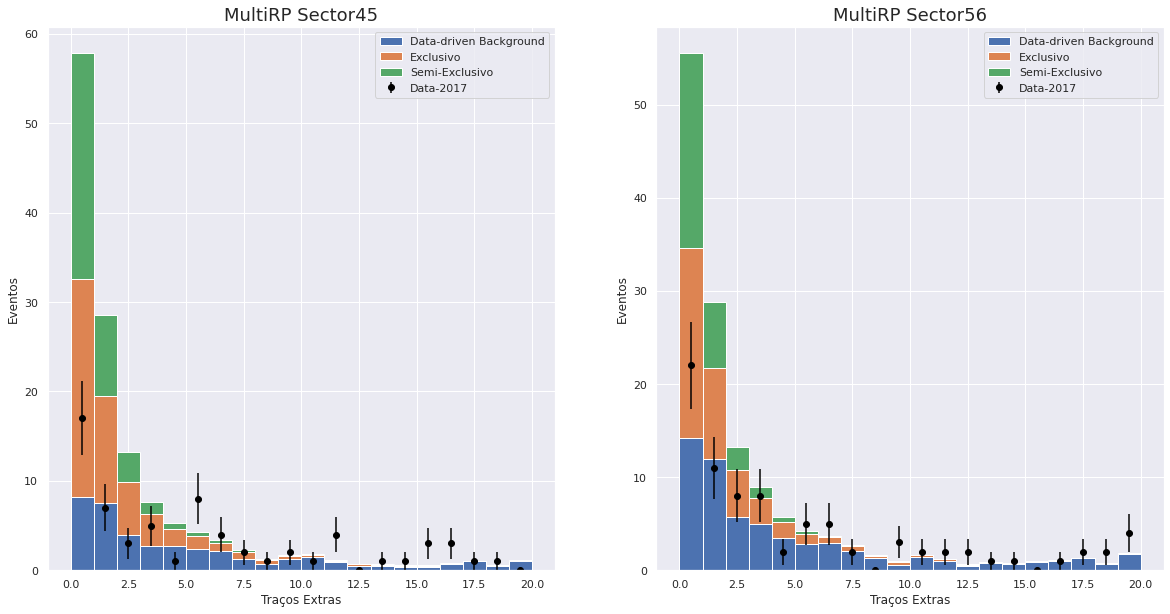

In [55]:
fig, axes = plt.subplots( 1, 2, figsize=(20,10) )

var_ = "ExtraPfCands"
bins_ = 20
range_ = (0,20)

counts_1, bin_edges_1 = np.histogram( df_data[ var_ ][ msk_data_1 ], bins=bins_, range=range_ )
errors_1 = np.sqrt( counts_1 )
bin_centres_1 = ( bin_edges_1[:-1] + bin_edges_1[1:] ) / 2.
axes[0].errorbar(bin_centres_1, counts_1, yerr=errors_1, fmt='o', label = 'Data-2017', color = 'black')

counts_2, bin_edges_2 = np.histogram( df_data[ var_ ][ msk_data_2 ], bins=bins_, range=range_ )
errors_2 = np.sqrt( counts_2 )
bin_centres_2 = ( bin_edges_2[:-1] + bin_edges_2[1:] ) / 2.
axes[1].errorbar(bin_centres_2, counts_2, yerr=errors_2, fmt='o', label = 'Data-2017', color = 'black')

idx_ymax_ = np.argmax( np.concatenate( [counts_1, counts_2] ) )
y_max = np.concatenate( [counts_1, counts_2] )[idx_ymax_] + 2*np.concatenate( [errors_1, errors_2] )[idx_ymax_]
print ( "y max. = {}".format(y_max) )

axes[0].hist( [MonteCarlo_DrellYan[ var_ ][ msk_bkg_pred_1 ] ,
               MonteCarlo_Exclusive[ var_ ][ msk_sgex_pred_1 ],
               MonteCarlo_SemiExclusive[ var_ ][ msk_sgsex_pred_1 ]], stacked = True, bins=bins_, range=range_, weights = [weights_1_back*Norm_Test,
                                                                                                                           MonteCarlo_Exclusive.Weight[ msk_sgex_pred_1 ]*Norm_Test,
                                                                                                                           MonteCarlo_SemiExclusive.Weight[ msk_sgsex_pred_1 ]*Norm_Test], label = ["Data-driven Background","Exclusivo","Semi-Exclusivo"] )
axes[0].legend()
axes[0].set_title("MultiRP Sector45", fontsize=18)
axes[0].set_xlabel("Traços Extras")
axes[0].set_ylabel('Eventos')

axes[1].hist( [MonteCarlo_DrellYan[ var_ ][ msk_bkg_pred_2 ] ,
               MonteCarlo_Exclusive[ var_ ][ msk_sgex_pred_2 ],
               MonteCarlo_SemiExclusive[ var_ ][ msk_sgsex_pred_2 ]], stacked = True, bins=bins_, range=range_, weights = [weights_2_back*Norm_Test,
                                                                                                                           MonteCarlo_Exclusive.Weight[ msk_sgex_pred_2 ]*Norm_Test,
                                                                                                                           MonteCarlo_SemiExclusive.Weight[ msk_sgsex_pred_2 ]*Norm_Test], label = ["Data-driven Background","Exclusivo","Semi-Exclusivo"] )
axes[1].legend()
axes[1].set_title("MultiRP Sector56", fontsize=18)
axes[1].set_xlabel("Traços Extras")
axes[1].set_ylabel('Eventos')

y max. = 28.94427190999916


Text(0, 0.5, 'Eventos')

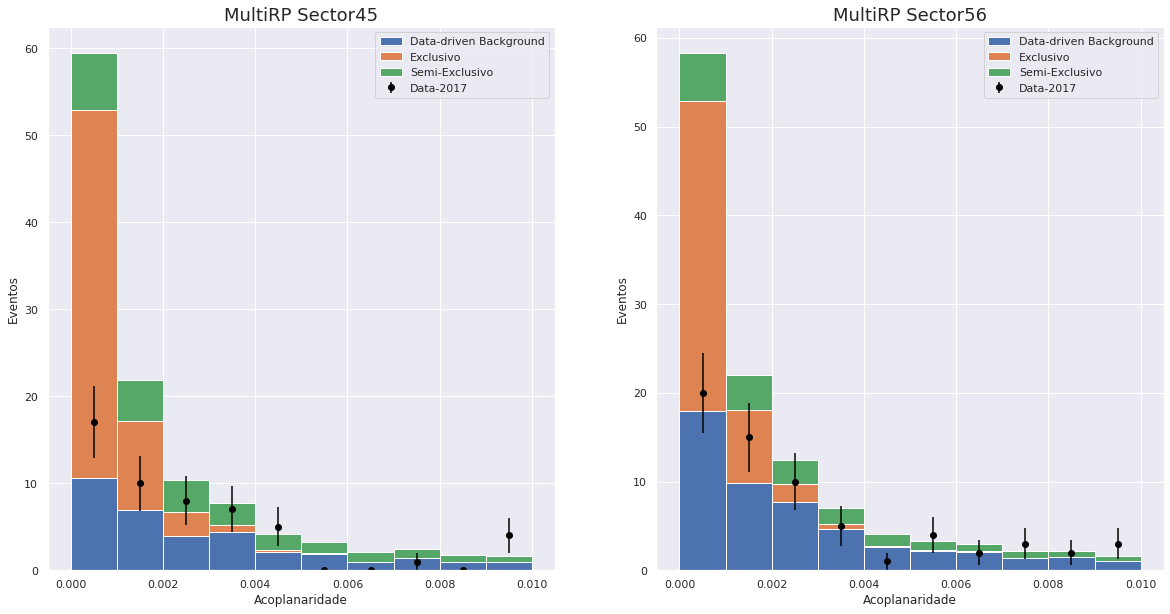

In [56]:
fig, axes = plt.subplots( 1, 2, figsize=(20,10) )

var_ = "Acopl"
bins_ = 10
range_ = (0.,0.01)

counts_1, bin_edges_1 = np.histogram( df_data[ var_ ][ msk_data_1 ], bins=bins_, range=range_ )
errors_1 = np.sqrt( counts_1 )
bin_centres_1 = ( bin_edges_1[:-1] + bin_edges_1[1:] ) / 2.
axes[0].errorbar(bin_centres_1, counts_1, yerr=errors_1, fmt='o', label = 'Data-2017', color = 'black')

counts_2, bin_edges_2 = np.histogram( df_data[ var_ ][ msk_data_2 ], bins=bins_, range=range_ )
errors_2 = np.sqrt( counts_2 )
bin_centres_2 = ( bin_edges_2[:-1] + bin_edges_2[1:] ) / 2.
axes[1].errorbar(bin_centres_2, counts_2, yerr=errors_2, fmt='o', label = 'Data-2017', color = 'black')

idx_ymax_ = np.argmax( np.concatenate( [counts_1, counts_2] ) )
y_max = np.concatenate( [counts_1, counts_2] )[idx_ymax_] + 2*np.concatenate( [errors_1, errors_2] )[idx_ymax_]
print ( "y max. = {}".format(y_max) )

axes[0].hist( [MonteCarlo_DrellYan[ var_ ][ msk_bkg_pred_1 ] ,
               MonteCarlo_Exclusive[ var_ ][ msk_sgex_pred_1 ],
               MonteCarlo_SemiExclusive[ var_ ][ msk_sgsex_pred_1 ]], stacked = True, bins=bins_, range=range_, weights = [weights_1_back*Norm_Test,
                                                                                                                           MonteCarlo_Exclusive.Weight[ msk_sgex_pred_1 ]*Norm_Test,
                                                                                                                           MonteCarlo_SemiExclusive.Weight[ msk_sgsex_pred_1 ]*Norm_Test], label = ["Data-driven Background","Exclusivo","Semi-Exclusivo"] )
axes[0].legend()
axes[0].set_title("MultiRP Sector45", fontsize=18)
axes[0].set_xlabel("Acoplanaridade")
axes[0].set_ylabel('Eventos')

axes[1].hist( [MonteCarlo_DrellYan[ var_ ][ msk_bkg_pred_2 ] ,
               MonteCarlo_Exclusive[ var_ ][ msk_sgex_pred_2 ],
               MonteCarlo_SemiExclusive[ var_ ][ msk_sgsex_pred_2 ]], stacked = True, bins=bins_, range=range_, weights = [weights_2_back*Norm_Test,
                                                                                                                           MonteCarlo_Exclusive.Weight[ msk_sgex_pred_2 ]*Norm_Test,
                                                                                                                           MonteCarlo_SemiExclusive.Weight[ msk_sgsex_pred_2 ]*Norm_Test], label = ["Data-driven Background","Exclusivo","Semi-Exclusivo"] )
axes[1].legend()
axes[1].set_title("MultiRP Sector56", fontsize=18)
axes[1].set_xlabel("Acoplanaridade")
axes[1].set_ylabel('Eventos')

In [57]:
!python3 -m pip install --user coffea numba lz4 uproot six awkward1 mplhep cloudpickle packaging uproot-methods pandas numpy uproot4 scipy awkward tqdm

In [58]:
import coffea.hist as hist

# HISTOGRAMAS PARA O SETOR 45

In [59]:
histo = hist.Hist("Events",
        hist.Cat("sample", ""),
        hist.Bin("pt", "$P_{T_{\mu^{+}\mu^{-}}}(GeV/c)$", 15, 0, 10),
        hist.Bin("massa_inv", "$M_{\mu^{+}\mu^{-}}(GeV/c^{2})$", 15, 0, 500),
        hist.Bin("acopla", "Acoplanaridade", 20, 0, 0.004),   
        hist.Bin("extratracks", "Traços Extras", 20, 0, 40)
        )
histo.fill(
    sample = "Data-driven Background",
    pt = np.array(MonteCarlo_DrellYan[ msk_bkg_pred_1 ].pt),
    massa_inv = np.array(MonteCarlo_DrellYan[ msk_bkg_pred_1 ].InvMass),
    acopla = np.array(MonteCarlo_DrellYan[ msk_bkg_pred_1 ].Acopl),
    extratracks = np.array(MonteCarlo_DrellYan[ msk_bkg_pred_1 ].ExtraPfCands),
    weight = np.array(MonteCarlo_DrellYan[ msk_bkg_pred_1 ].Weight*Norm_Test)
    )
histo.fill(
    sample = "Exclusivo",
    pt = np.array(MonteCarlo_Exclusive[ msk_sgex_pred_1 ].pt),
    massa_inv = np.array(MonteCarlo_Exclusive[ msk_sgex_pred_1 ].InvMass),
    acopla = np.array(MonteCarlo_Exclusive[ msk_sgex_pred_1 ].Acopl),   
    extratracks = np.array(MonteCarlo_Exclusive[ msk_sgex_pred_1 ].ExtraPfCands), 
    weight = np.array(MonteCarlo_Exclusive[ msk_sgex_pred_1 ].Weight*Norm_Test)
    )
histo.fill(
    sample = "Semi-Exclusivo",
    pt = np.array(MonteCarlo_SemiExclusive[ msk_sgsex_pred_1 ].pt),
    massa_inv = np.array(MonteCarlo_SemiExclusive[ msk_sgsex_pred_1 ].InvMass),
    acopla = np.array(MonteCarlo_SemiExclusive[ msk_sgsex_pred_1 ].Acopl),   
    extratracks = np.array(MonteCarlo_SemiExclusive[ msk_sgsex_pred_1 ].ExtraPfCands), 
    weight = np.array(MonteCarlo_SemiExclusive[ msk_sgsex_pred_1 ].Weight*Norm_Test)
    )
histo.fill(
    sample = "Data-2017",
    pt = np.array(df_data[msk_data_1].pt),
    massa_inv = np.array(df_data[msk_data_1].InvMass),
    acopla = np.array(df_data[msk_data_1].Acopl),  
    extratracks = np.array(df_data[ msk_data_1 ].ExtraPfCands) 
    )

plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

fill_opts = {
    'edgecolor': (0,0,0,0.3),
    'alpha': 0.8
}
error_opts = {
    'label': 'Stat. Unc.',
    'hatch': '///',
    'facecolor': 'none',
    'edgecolor': (0,0,0,1),
    'linewidth': 0
}
data_err_opts = {
    'linestyle': 'none',
    'marker': '.',
    'markersize': 10.,
    'color': 'k',
    'elinewidth': 1,
}

import re
notdata = re.compile('(?!Data-2017)')

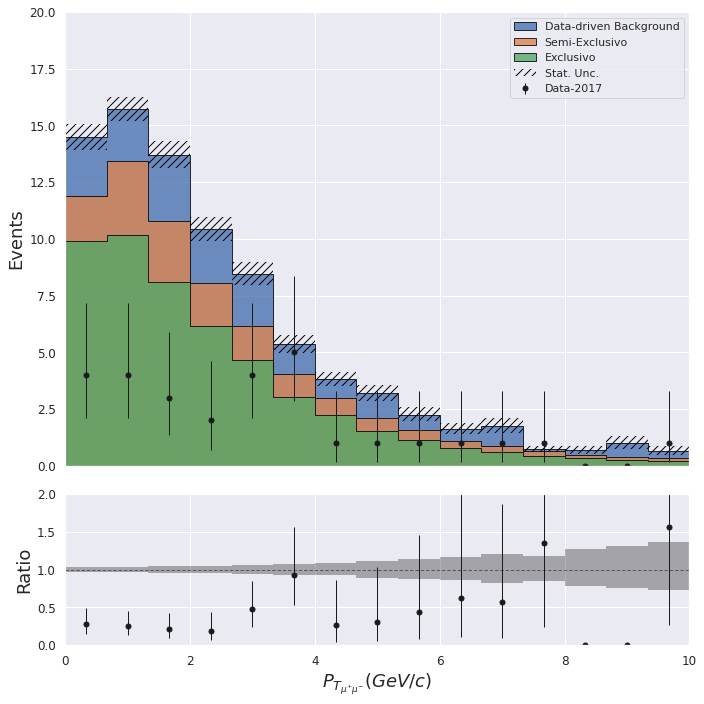

In [60]:
fig, (ax, rax) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(10,10),
    gridspec_kw={"height_ratios": (3, 1)},
    sharex=True
)
fig.subplots_adjust(hspace=.07)

pt1hist = histo.sum("extratracks", "massa_inv", 'acopla')

hist.plot1d(
    pt1hist['Data-2017'],
    overlay="sample",
    clear=True,
    ax=ax,
    error_opts=data_err_opts
    )
hist.plot1d(
    pt1hist[notdata],
    overlay='sample',
    stack=True,
    order = ['Exclusivo', "Semi-Exclusivo", "Data-driven Background"],
    clear=False,
    ax=ax,
    line_opts=False,
    fill_opts=fill_opts,
    error_opts=error_opts
    )

#plt.yscale('log')
#plt.style.use([hep.style.ROOT, hep.style.firamath])
ax.autoscale(axis='x', tight=True)
ax.set_ylim(0, 20)
ax.set_xlabel(None)
leg = ax.legend()

hist.plotratio(
    num=pt1hist['Data-2017'].sum("sample"),
    denom=pt1hist[notdata].sum("sample"),
    ax=rax,
    error_opts=data_err_opts,
    denom_fill_opts={},
    guide_opts={},
    unc='num'
)
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)
plt.tight_layout()
plt.show()
#plt.savefig('/home/matheus/test/hist_pt_normalized.png')
plt.close()

No handles with labels found to put in legend.
/root/.local/lib/python3.6/site-packages/coffea/hist/plot.py:357: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/root/.local/lib/python3.6/site-packages/coffea/hist/plot.py:364: RuntimeWarning: invalid value encountered in true_divide
  rsumw_err = np.abs(poisson_interval(rsumw, sumw2_num / sumw_denom**2) - rsumw)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:873: RuntimeWarning: invalid value encountered in greater
  cond = logical_and(cond, (asarray(arg) > 0))
/root/.local/lib/python3.6/site-packages/coffea/hist/plot.py:378: RuntimeWarning: invalid value encountered in true_divide
  denom_unc = poisson_interval(unity, sumw2_denom / sumw_denom**2)


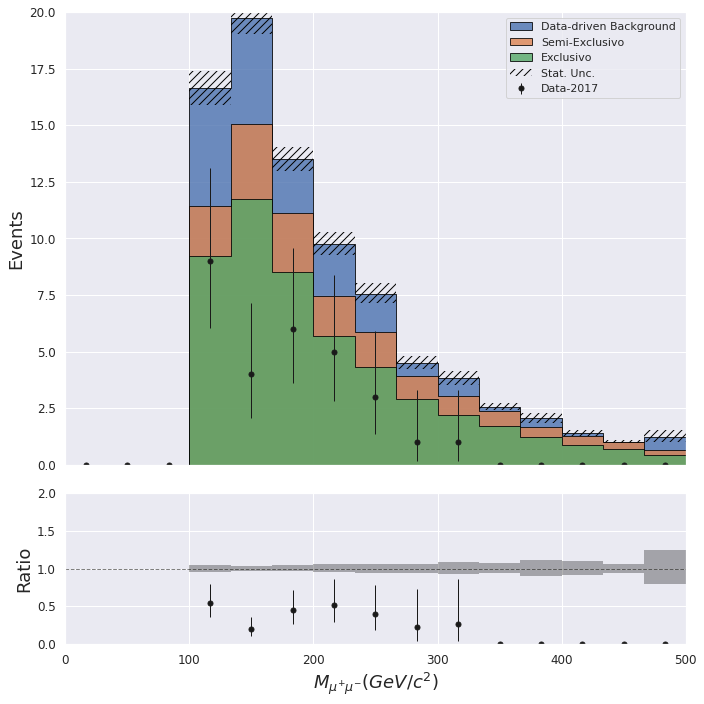

In [61]:
masshist = histo.sum("pt", "extratracks", 'acopla')

fig, (ax, rax) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(10,10),
    gridspec_kw={"height_ratios": (3, 1)},
    sharex=True

)
fig.subplots_adjust(hspace=.07)

hist.plot1d(
    masshist[notdata],
    overlay='sample',
    stack=True,
    ax=ax,
    order = ['Exclusivo', "Semi-Exclusivo", "Data-driven Background"],    
    line_opts=None,
    fill_opts=fill_opts,
    error_opts=error_opts 
)
hist.plot1d(
    masshist['Data-2017'],
    overlay="sample",
    ax=ax,
    clear=False,
    error_opts=data_err_opts,
    density = False
)
plt.ylim(0, 1750)
#plt.yscale('log')
plt.legend(loc="upper right")
ax.autoscale(axis='x', tight=True)
ax.set_ylim(0, 20)
ax.set_xlabel(None)
#ax = hep.cms.cmslabel(data=False, paper=False, year='$18.34 fb^{-1}$', ax=ax)
leg = ax.legend()

hist.plotratio(
    num=masshist['Data-2017'].sum("sample"),
    denom=masshist[notdata].sum("sample"),
    ax=rax,
    error_opts=data_err_opts,
    denom_fill_opts={},
    guide_opts={},
    unc='num'
)
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)
plt.tight_layout()
plt.show()
#plt.savefig('/home/matheus/test/hist_massa_normalized.png')
plt.close()

No handles with labels found to put in legend.


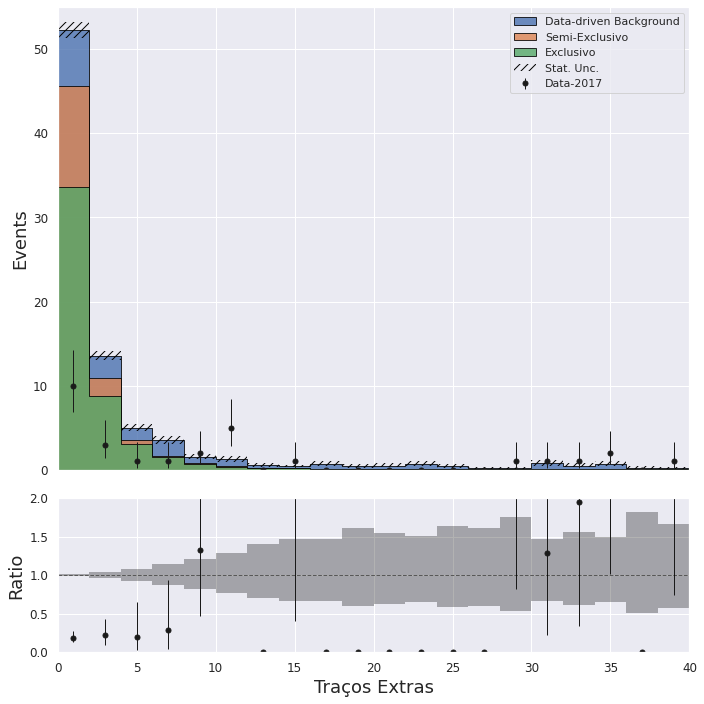

In [63]:
extrahist = histo.sum("pt", "massa_inv", 'acopla')

fig, (ax, rax) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(10,10),
    gridspec_kw={"height_ratios": (3, 1)},
    sharex=True

)
fig.subplots_adjust(hspace=.07)

hist.plot1d(
    extrahist[notdata],
    overlay='sample',
    stack=True,
    ax=ax,
    order = ['Exclusivo', "Semi-Exclusivo", "Data-driven Background"],    
    line_opts=None,
    fill_opts=fill_opts,
    error_opts=error_opts 
)
hist.plot1d(
    extrahist['Data-2017'],
    overlay="sample",
    ax=ax,
    clear=False,
    error_opts=data_err_opts,
    density = False
)
plt.ylim(0, 1750)
#plt.yscale('log')
plt.legend(loc="upper right")
ax.autoscale(axis='x', tight=True)
ax.set_ylim(0, 55)
ax.set_xlabel(None)
#ax = hep.cms.cmslabel(data=False, paper=False, year='$18.34 fb^{-1}$', ax=ax)
leg = ax.legend()

hist.plotratio(
    num=extrahist['Data-2017'].sum("sample"),
    denom=extrahist[notdata].sum("sample"),
    ax=rax,
    error_opts=data_err_opts,
    denom_fill_opts={},
    guide_opts={},
    unc='num'
)
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)
plt.tight_layout()
plt.show()
#plt.savefig('/home/matheus/test/hist_massa_normalized.png')
plt.close()

# HISTOGRAMAS PARA O SETOR 56

In [64]:
histo = hist.Hist("Events",
        hist.Cat("sample", ""),
        hist.Bin("pt", "$P_{T_{\mu^{+}\mu^{-}}}(GeV/c)$", 15, 0, 10),
        hist.Bin("massa_inv", "$M_{\mu^{+}\mu^{-}}(GeV/c^{2})$", 15, 0, 500),
        hist.Bin("acopla", "Acoplanaridade", 20, 0, 0.004),   
        hist.Bin("extratracks", "Traços Extras", 20, 0, 40)
        )
histo.fill(
    sample = "Data-driven Background",
    pt = np.array(MonteCarlo_DrellYan[ msk_bkg_pred_2 ].pt),
    massa_inv = np.array(MonteCarlo_DrellYan[ msk_bkg_pred_2 ].InvMass),
    acopla = np.array(MonteCarlo_DrellYan[ msk_bkg_pred_2 ].Acopl),
    extratracks = np.array(MonteCarlo_DrellYan[ msk_bkg_pred_2 ].ExtraPfCands),
    weight = np.array(MonteCarlo_DrellYan[ msk_bkg_pred_2 ].Weight*Norm_Test)
    )
histo.fill(
    sample = "Exclusivo",
    pt = np.array(MonteCarlo_Exclusive[ msk_sgex_pred_2 ].pt),
    massa_inv = np.array(MonteCarlo_Exclusive[ msk_sgex_pred_2 ].InvMass),
    acopla = np.array(MonteCarlo_Exclusive[ msk_sgex_pred_2 ].Acopl),   
    extratracks = np.array(MonteCarlo_Exclusive[ msk_sgex_pred_2 ].ExtraPfCands), 
    weight = np.array(MonteCarlo_Exclusive[ msk_sgex_pred_2 ].Weight*Norm_Test)
    )
histo.fill(
    sample = "Semi-Exclusivo",
    pt = np.array(MonteCarlo_SemiExclusive[ msk_sgsex_pred_2 ].pt),
    massa_inv = np.array(MonteCarlo_SemiExclusive[ msk_sgsex_pred_2 ].InvMass),
    acopla = np.array(MonteCarlo_SemiExclusive[ msk_sgsex_pred_2 ].Acopl),   
    extratracks = np.array(MonteCarlo_SemiExclusive[ msk_sgsex_pred_2 ].ExtraPfCands), 
    weight = np.array(MonteCarlo_SemiExclusive[ msk_sgsex_pred_2 ].Weight*Norm_Test)
    )
histo.fill(
    sample = "Data-2017",
    pt = np.array(df_data[msk_data_2].pt),
    massa_inv = np.array(df_data[msk_data_2].InvMass),
    acopla = np.array(df_data[msk_data_2].Acopl),  
    extratracks = np.array(df_data[ msk_data_2].ExtraPfCands) 
    )

plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

fill_opts = {
    'edgecolor': (0,0,0,0.3),
    'alpha': 0.8
}
error_opts = {
    'label': 'Stat. Unc.',
    'hatch': '///',
    'facecolor': 'none',
    'edgecolor': (0,0,0,1),
    'linewidth': 0
}
data_err_opts = {
    'linestyle': 'none',
    'marker': '.',
    'markersize': 10.,
    'color': 'k',
    'elinewidth': 1,
}

import re
notdata = re.compile('(?!Data-2017)')

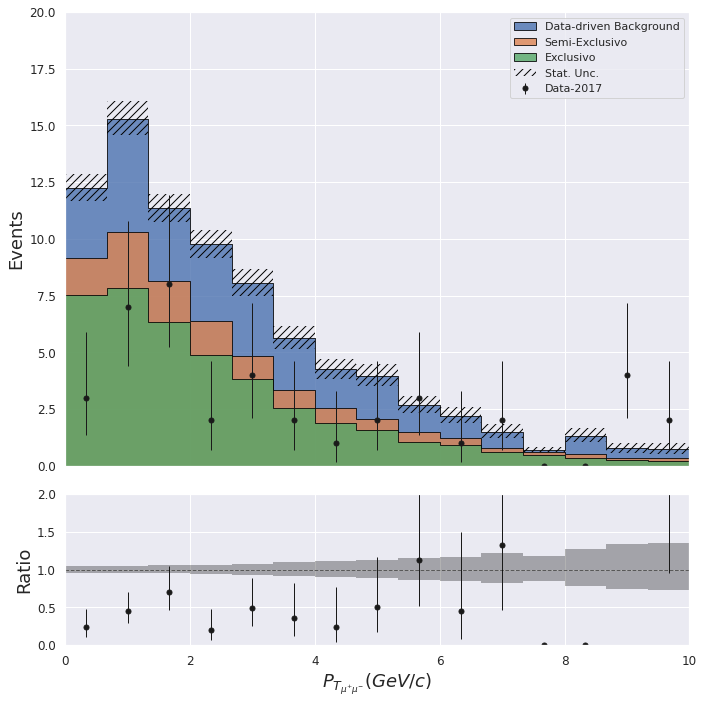

In [65]:
fig, (ax, rax) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(10,10),
    gridspec_kw={"height_ratios": (3, 1)},
    sharex=True
)
fig.subplots_adjust(hspace=.07)

pt1hist = histo.sum("extratracks", "massa_inv", 'acopla')

hist.plot1d(
    pt1hist['Data-2017'],
    overlay="sample",
    clear=True,
    ax=ax,
    error_opts=data_err_opts
    )
hist.plot1d(
    pt1hist[notdata],
    overlay='sample',
    stack=True,
    order = ['Exclusivo', "Semi-Exclusivo", "Data-driven Background"],
    clear=False,
    ax=ax,
    line_opts=False,
    fill_opts=fill_opts,
    error_opts=error_opts
    )

#plt.yscale('log')
#plt.style.use([hep.style.ROOT, hep.style.firamath])
ax.autoscale(axis='x', tight=True)
ax.set_ylim(0, 20)
ax.set_xlabel(None)
leg = ax.legend()

hist.plotratio(
    num=pt1hist['Data-2017'].sum("sample"),
    denom=pt1hist[notdata].sum("sample"),
    ax=rax,
    error_opts=data_err_opts,
    denom_fill_opts={},
    guide_opts={},
    unc='num'
)
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)
plt.tight_layout()
plt.show()
#plt.savefig('/home/matheus/test/hist_pt_normalized.png')
plt.close()

No handles with labels found to put in legend.
/root/.local/lib/python3.6/site-packages/coffea/hist/plot.py:357: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/root/.local/lib/python3.6/site-packages/coffea/hist/plot.py:364: RuntimeWarning: invalid value encountered in true_divide
  rsumw_err = np.abs(poisson_interval(rsumw, sumw2_num / sumw_denom**2) - rsumw)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:873: RuntimeWarning: invalid value encountered in greater
  cond = logical_and(cond, (asarray(arg) > 0))
/root/.local/lib/python3.6/site-packages/coffea/hist/plot.py:378: RuntimeWarning: invalid value encountered in true_divide
  denom_unc = poisson_interval(unity, sumw2_denom / sumw_denom**2)


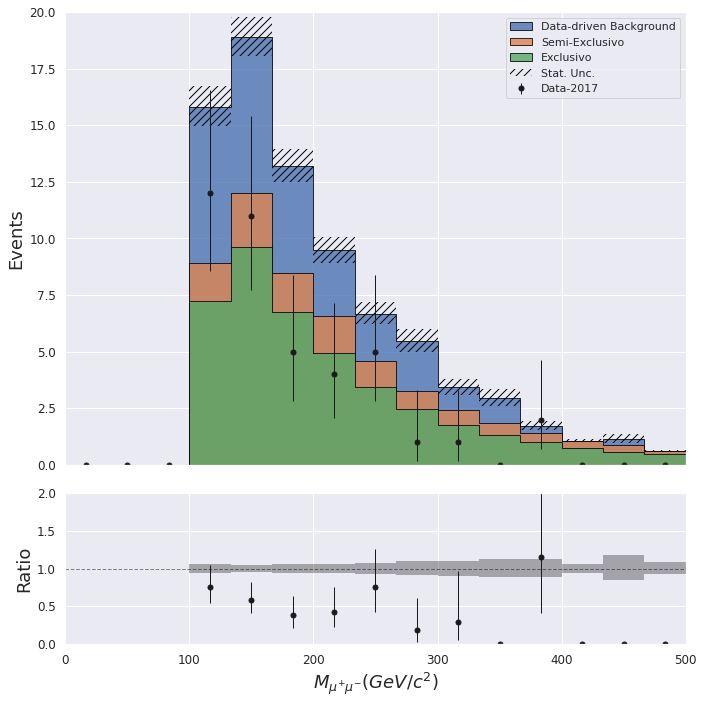

In [66]:

masshist = histo.sum("pt", "extratracks", 'acopla')

fig, (ax, rax) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(10,10),
    gridspec_kw={"height_ratios": (3, 1)},
    sharex=True

)
fig.subplots_adjust(hspace=.07)

hist.plot1d(
    masshist[notdata],
    overlay='sample',
    stack=True,
    ax=ax,
    order = ['Exclusivo', "Semi-Exclusivo", "Data-driven Background"],    
    line_opts=None,
    fill_opts=fill_opts,
    error_opts=error_opts 
)
hist.plot1d(
    masshist['Data-2017'],
    overlay="sample",
    ax=ax,
    clear=False,
    error_opts=data_err_opts,
    density = False
)
plt.ylim(0, 1750)
#plt.yscale('log')
plt.legend(loc="upper right")
ax.autoscale(axis='x', tight=True)
ax.set_ylim(0, 20)
ax.set_xlabel(None)
#ax = hep.cms.cmslabel(data=False, paper=False, year='$18.34 fb^{-1}$', ax=ax)
leg = ax.legend()

hist.plotratio(
    num=masshist['Data-2017'].sum("sample"),
    denom=masshist[notdata].sum("sample"),
    ax=rax,
    error_opts=data_err_opts,
    denom_fill_opts={},
    guide_opts={},
    unc='num'
)
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)
plt.tight_layout()
plt.show()
#plt.savefig('/home/matheus/test/hist_massa_normalized.png')
plt.close()

No handles with labels found to put in legend.


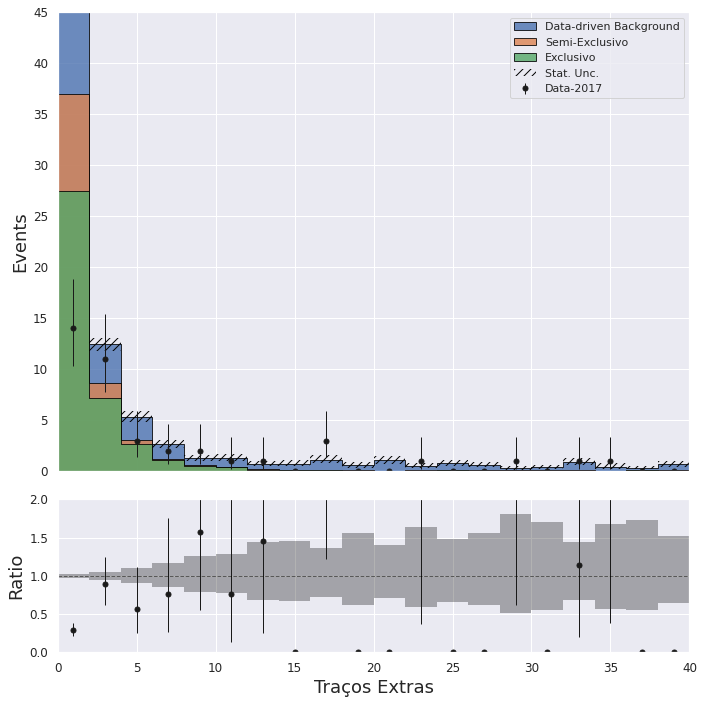

In [67]:
extrahist = histo.sum("pt", "massa_inv", 'acopla')

fig, (ax, rax) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(10,10),
    gridspec_kw={"height_ratios": (3, 1)},
    sharex=True

)
fig.subplots_adjust(hspace=.07)

hist.plot1d(
    extrahist[notdata],
    overlay='sample',
    stack=True,
    ax=ax,
    order = ['Exclusivo', "Semi-Exclusivo", "Data-driven Background"],    
    line_opts=None,
    fill_opts=fill_opts,
    error_opts=error_opts 
)
hist.plot1d(
    extrahist['Data-2017'],
    overlay="sample",
    ax=ax,
    clear=False,
    error_opts=data_err_opts,
    density = False
)
plt.ylim(0, 1750)
#plt.yscale('log')
plt.legend(loc="upper right")
ax.autoscale(axis='x', tight=True)
ax.set_ylim(0, 45)
ax.set_xlabel(None)
#ax = hep.cms.cmslabel(data=False, paper=False, year='$18.34 fb^{-1}$', ax=ax)
leg = ax.legend()

hist.plotratio(
    num=extrahist['Data-2017'].sum("sample"),
    denom=extrahist[notdata].sum("sample"),
    ax=rax,
    error_opts=data_err_opts,
    denom_fill_opts={},
    guide_opts={},
    unc='num'
)
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)
plt.tight_layout()
plt.show()
#plt.savefig('/home/matheus/test/hist_massa_normalized.png')
plt.close()